# Postprocessing Semi-Boosted

In [2]:
import os
from HH4b import utils, plotting, postprocessing
from HH4b.postprocessing import Region, weight_shifts
from HH4b.utils import ShapeVar, CUT_MAX_VAL
from HH4b.hh_vars import samples, data_key, bg_keys, sig_keys, LUMI

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

from copy import deepcopy

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 16})

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = "../../../"
# almost there but jets were not selected with eta<2.5
# path_to_dir = f"{MAIN_DIR}/../data/matching/23Nov13_WSel_v9_private/"
path_to_dir = f"{MAIN_DIR}/../data/matching/23Nov17_v9_private/"
year = "2018"

# make plot and template directory
date = "23Nov17"
plot_dir = f"{MAIN_DIR}/plots/PostProcessing/{date}/{year}"
template_dir = f"templates/{date}/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {template_dir}/cutflows/{year}")

from HH4b.hh_vars import samples
samples = deepcopy(samples[year])
sample_dirs = {path_to_dir: samples}

In [5]:
sample_dirs

{'../../..//../data/matching/23Nov17_v9_private/': {'hh4b': ['GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8'],
  'qcd': ['QCD_HT-1000to1500-13TeV',
   'QCD_HT-1500to2000-13TeV',
   'QCD_HT-2000toInf-13TeV',
   'QCD_HT-200to300-13TeV',
   'QCD_HT-300to500-13TeV',
   'QCD_HT-500to700-13TeV',
   'QCD_HT-700to1000-13TeV'],
  'data': ['Run2018A', 'Run2018B', 'Run2018C', 'Run2018D'],
  'ttbar': ['TTTo2L2Nu_13TeV', 'TTToHadronic_13TeV', 'TTToSemiLeptonic_13TeV'],
  'vjets': ['WJetsToQQ_HT-200to400_13TeV',
   'WJetsToQQ_HT-400to600_13TeV',
   'WJetsToQQ_HT-600to800_13TeV',
   'WJetsToQQ_HT-800toInf_13TeV',
   'ZJetsToQQ_HT-200to400_13TeV',
   'ZJetsToQQ_HT-400to600_13TeV',
   'ZJetsToQQ_HT-600to800_13TeV',
   'ZJetsToQQ_HT-800toInf_13TeV'],
  'diboson': ['ZZTo4B01j_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8'],
  'gghtobb': ['GluGluHToBB_M-125_TuneCP5_MINLO_NNLOPS_13TeV-powheg-pythia8'],
  'vbfhtobb': ['VBFHToBB_M-125_dipoleRecoilOn_TuneCP5_13TeV-powheg-pythia8'],
  'vhtobb': ['WminusH

In [5]:
df = pd.read_parquet("../../../../data/matching/23Nov17_v9_private/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet")
list(df.columns)

[('ht', 0),
 ('nCentralJets', 0),
 ('nOutsideJets', 0),
 ('nFatJets', 0),
 ('GenHiggsEta', 0),
 ('GenHiggsEta', 1),
 ('GenHiggsPhi', 0),
 ('GenHiggsPhi', 1),
 ('GenHiggsMass', 0),
 ('GenHiggsMass', 1),
 ('GenHiggsPt', 0),
 ('GenHiggsPt', 1),
 ('GenbEta', 0),
 ('GenbEta', 1),
 ('GenbEta', 2),
 ('GenbEta', 3),
 ('GenbPhi', 0),
 ('GenbPhi', 1),
 ('GenbPhi', 2),
 ('GenbPhi', 3),
 ('GenbMass', 0),
 ('GenbMass', 1),
 ('GenbMass', 2),
 ('GenbMass', 3),
 ('GenbPt', 0),
 ('GenbPt', 1),
 ('GenbPt', 2),
 ('GenbPt', 3),
 ('ak4JetHiggsMatch', 0),
 ('ak4JetHiggsMatch', 1),
 ('ak4JetHiggsMatch', 2),
 ('ak4JetHiggsMatch', 3),
 ('ak4JetHiggsMatch', 4),
 ('ak4JetHiggsMatch', 5),
 ('ak4JetHiggsMatchIndex', 0),
 ('ak4JetHiggsMatchIndex', 1),
 ('ak4JetHiggsMatchIndex', 2),
 ('ak4JetHiggsMatchIndex', 3),
 ('ak4JetHiggsMatchIndex', 4),
 ('ak4JetHiggsMatchIndex', 5),
 ('ak4JethadronFlavour', 0),
 ('ak4JethadronFlavour', 1),
 ('ak4JethadronFlavour', 2),
 ('ak4JethadronFlavour', 3),
 ('ak4JethadronFlavour', 4),

In [6]:
filters = [
    # one good fatjet (fatjet with index 0 has the largest Xbb score)
    ("('ak8FatJetPt', '0')", ">=", 300),
    ("('ak8FatJetMsd', '0')", ">=", 60),
    ("('ak8FatJetPNetXbb', '0')", ">=", 0.9734),  # medium WP
    # second fatjet has lower Xbb score
    ("('ak8FatJetPNetXbb', '1')", "<", 0.9880),  # tight WP
    # ("('ak8FatJetPNetXbb', '1')", "<", 0.9734),  # medium WP
    # ("('ak8FatJetPNetXbb', '1')", "<", 0.9172), # loose WP
]

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples.keys()))

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples in sample_dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir,
            samples,
            year,
            filters=filters,
        ),
    }

utils.add_to_cutflow(events_dict, "Preselection", "weight", cutflow)
print("\n", cutflow)

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
Loading QCD_HT-200to300-13TeV
Loading QCD_HT-1000to1500-13TeV
Loading QCD_HT-500to700-13TeV
Loading QCD_HT-700to1000-13TeV
Loading QCD_HT-300to500-13TeV
Loading QCD_HT-1500to2000-13TeV
Loading QCD_HT-2000toInf-13TeV
Loading Run2018A
Loading Run2018C
Loading Run2018D
Loading Run2018B
Loading TTToHadronic_13TeV
Loading TTToSemiLeptonic_13TeV
Loading TTTo2L2Nu_13TeV
Loading ZJetsToQQ_HT-400to600_13TeV
Loading WJetsToQQ_HT-600to800_13TeV
Loading WJetsToQQ_HT-800toInf_13TeV
Loading WJetsToQQ_HT-200to400_13TeV
Loading ZJetsToQQ_HT-200to400_13TeV
Loading ZJetsToQQ_HT-800toInf_13TeV
Loading ZJetsToQQ_HT-600to800_13TeV
Loading WJetsToQQ_HT-400to600_13TeV
Loading ZZTo4B01j_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8
Loading GluGluHToBB_M-125_TuneCP5_MINLO_NNLOPS_13TeV-powheg-pythia8
Loading VBFHToBB_M-125_dipoleRecoilOn_TuneCP5_13TeV-powheg-pythia8
Loading WplusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8
Loading ZH_HToBB_ZToQQ_M-

In [7]:
for key,events in events_dict.items():
    print(key, len(events))

hh4b 16934
qcd 21203
data 179968
ttbar 363766
vjets 42608
diboson 79403
gghtobb 1634
vbfhtobb 1721
vhtobb 25943
tthtobb 125540


## Discriminator variables

In [7]:
import vector

def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [19]:
events.ak4JetOutsidebtagPNetProbb

0         1         2         3             4             5
0       0.868961  0.136897  0.006412  0.019220      0.008519      0.011070
1       0.997986  0.961903  0.023145  0.006817      0.022713      0.009239
2       0.984380  0.973485  0.910023  0.034095      0.009683      0.033072
3       0.212848  0.226530  0.012299  0.015050      0.001965      0.005824
4       0.999067  0.838231  0.993367  0.033913      0.015753      0.005880
...          ...       ...       ...       ...           ...           ...
125535  0.996173  0.991208  0.926521  0.005725      0.002599      0.011035
125536  0.900944  0.211356  0.078694  0.053525      0.013406      0.008765
125537  0.925364  0.782766  0.009691  0.007181      0.001209      0.001047
125538  0.942156  0.286837  0.011574  0.003299 -99999.000000 -99999.000000
125539  0.886543  0.053071  0.098375  0.037029      0.014498      0.018832

[125540 rows x 6 columns]

In [41]:
# Particle Net AK4 2018 WPs (and 2017)
# j.pt > 25 and abs(j.eta) < 2.4 and (j.jetId & 4)
# apply jet puId only for CHS jets
# veto jet from looseleptons
jetTagWPs = {
    54: '(pn_b_plus_c>0.5) & (pn_b_vs_c>0.99)',
    53: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.99) & (pn_b_vs_c>0.96)',
    52: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.96) & (pn_b_vs_c>0.88)',
    51: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.88) & (pn_b_vs_c>0.70)',
    50: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.70) & (pn_b_vs_c>0.40)',

    # 44: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.05)',
    # 43: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.15) & (pn_b_vs_c>0.05)',
    # 42: '(pn_b_plus_c>0.5) & (pn_b_vs_c<=0.40) & (pn_b_vs_c>0.15)',
    # 41: '(pn_b_plus_c<=0.5) & (pn_b_plus_c>0.2)',
    # 40: '(pn_b_plus_c<=0.2) & (pn_b_plus_c>0.1)',

    # 0: '(pn_b_plus_c<=0.1)',
}

for key in events_dict.keys():
    events = events_dict[key]

    pnet_b = events.ak4JetOutsidebtagPNetProbb
    pnet_bb = events.ak4JetOutsidebtagPNetProbbb
    pnet_c = events.ak4JetOutsidebtagPNetProbc
    pnet_cc = events.ak4JetOutsidebtagPNetProbcc
    pnet_uds = events.ak4JetOutsidebtagPNetProbuds
    pnet_g = events.ak4JetOutsidebtagPNetProbg

    pn_b = (pnet_b + pnet_bb) / (pnet_c + pnet_cc + pnet_uds + pnet_g)
    pn_c = (pnet_c + pnet_cc) / (pnet_b + pnet_bb + pnet_uds + pnet_g)
    # pn_uds = (pnet_uds) / (pnet_b + pnet_bb + pnet_c + pnet_cc + pnet_g)
    # pn_g = (pnet_g) / (pnet_b + pnet_bb + pnet_c + pnet_cc + pnet_uds)

    pn_b_plus_c = pn_b + pn_c
    pn_b_vs_c = pn_b / pn_b_plus_c

    j = {
        "pn_b_plus_c": pn_b_plus_c,
        "pn_b_vs_c": pn_b_vs_c,
    }
    pn_sel = {}
    for wp, expr in jetTagWPs.items():
        pn_sel[wp] = eval(expr, j)

    nbjets_pnet_ak4 = pn_sel[54] + pn_sel[53] + pn_sel[52] + pn_sel[51] + pn_sel[50]
    nbjets_pnet_ak4 = np.sum(nbjets_pnet_ak4, axis=1)
    events_dict[key]["nbjets_pnet_ak4"] = nbjets_pnet_ak4


In [42]:
events_dict["hh4b"]["nbjets_pnet_ak4"]

0        4
1        5
2        4
3        4
4        4
        ..
16929    3
16930    2
16931    3
16932    3
16933    5
Name: nbjets_pnet_ak4, Length: 16934, dtype: int64

In [62]:
hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

import hist
from matplotlib.lines import Line2D
from HH4b.plotting import color_by_sample

color_by_sample["qcd"] = "orange"

hr_pt_axis = hist.axis.Regular(40, 0, 1000, name="pt", label=r"Higgs resolved $p_T$ [GeV]")
hr_eta_axis = hist.axis.Regular(40, -2.5, 2.5, name="eta", label=r"Higgs resolved $\eta$")
hr_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs resolved mass [GeV]")

j3_pt_axis = hist.axis.Regular(40, 0, 1000, name="pt", label=r"$J_3$ (resolved) $p_T$ [GeV]")
j4_pt_axis = hist.axis.Regular(40, 0, 1000, name="pt", label=r"$J_4$ (resolved) $p_T$ [GeV]")
j3_btag_axis = hist.axis.Regular(40, 0, 1, name="btag", label=r"$J_3$ (resolved) DeepFlavB")
j4_btag_axis = hist.axis.Regular(40, 0, 1, name="btag", label=r"$J_4$ (resolved) DeepFlavB")
j_dr_axis = hist.axis.Regular(40, 0, 4, name="dr", label=r"$\Delta$ R($J_4, J_3$) (resolved)")
j_pt_ratio_axis = hist.axis.Regular(40, 0, 4, name="ptratio", label=r"$J_3/J_4$ $p_T$ [GeV]")

hb_pt_axis = hist.axis.Regular(40, 250, 1000, name="pt", label=r"Higgs boosted $p_T$ [GeV]")
hb_eta_axis = hist.axis.Regular(40, -2.5, 2.5, name="eta", label=r"Higgs boosted $\eta$")
hb_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"Higgs boosted PNet mass [GeV]")
hb_btag_axis = hist.axis.Regular(40, 0.97, 1, name="btag", label=r"Higgs boosted PNetXbb")

fj2_pt_axis = hist.axis.Regular(40, 250, 1000, name="pt", label=r"FatJet 2 $p_T$ [GeV]")
fj2_eta_axis = hist.axis.Regular(40, -2.5, 2.5, name="eta", label=r"FatJet 2 $\eta$")
fj2_mass_axis = hist.axis.Regular(40, 0, 300, name="mass", label=r"FatJet 2 PNet mass [GeV]")
fj2_btag_axis = hist.axis.Regular(80, 0, 1, name="btag", label=r"FatJet 2 PNetXbb")

hh_pt_axis = hist.axis.Regular(40, 0, 1000, name="pt", label=r"HH $p_T$ [GeV]")
hh_eta_axis = hist.axis.Regular(40, -2.5, 2.5, name="eta", label=r"HH $\eta$")
hh_mass_axis = hist.axis.Regular(40, 250, 2000, name="mass", label=r"HH mass [GeV]")

dR_axis = hist.axis.Regular(40, 0, 4, name="dr", label=r"$\Delta R(H_b,H_r)$")
dphi_axis = hist.axis.Regular(40, -3.2, 3.2, name="dphi", label=r"$\Delta \phi(H_b,H_r)$")
deta_axis = hist.axis.Regular(40, -3.2, 3.2, name="deta", label=r"$\Delta \eta(H_b,H_r)$")

njets_axis = hist.axis.Regular(7, 1, 8, name="njets", label="Number of outside jets")
nfatjets_axis = hist.axis.Regular(4, 1, 5, name="nfatjets", label="Number of fat jets")
nbjets_axis = hist.axis.Regular(7, 1, 8, name="nbjets", label="Number of outside jets (PNetAK4 B0-B4)")
nbjetsDM_axis = hist.axis.Regular(7, 1, 8, name="nbjets", label="Number of outside jets (DeepJet M)")
nbjetsDT_axis = hist.axis.Regular(7, 1, 8, name="nbjets", label="Number of outside jets (DeepJet T)")

cat_axis = hist.axis.StrCategory([], name="Sample", growth=True)

In [63]:
hists = {
    "j3_pt": hist.Hist(j3_pt_axis, cat_axis),
    "j4_pt": hist.Hist(j4_pt_axis, cat_axis),
    "j3_j4_dr": hist.Hist(j_dr_axis, cat_axis),
    "j3_btag": hist.Hist(j3_btag_axis, cat_axis),
    "j4_btag": hist.Hist(j4_btag_axis, cat_axis),
    "j4_j4_ratio": hist.Hist(j_pt_ratio_axis, cat_axis),
    "hr_pt": hist.Hist(hr_pt_axis, cat_axis),
    "hr_eta": hist.Hist(hr_eta_axis, cat_axis),
    "hr_mass": hist.Hist(hr_mass_axis, cat_axis),
    "hb_pt": hist.Hist(hb_pt_axis, cat_axis),
    "hb_eta": hist.Hist(hb_eta_axis, cat_axis),
    "hb_mass": hist.Hist(hb_mass_axis, cat_axis),
    "hb_btag": hist.Hist(hb_btag_axis, cat_axis),
    "fj2_pt": hist.Hist(fj2_pt_axis, cat_axis),
    "fj2_eta": hist.Hist(fj2_eta_axis, cat_axis),
    "fj2_mass": hist.Hist(fj2_mass_axis, cat_axis),
    "fj2_btag": hist.Hist(fj2_btag_axis, cat_axis),
    "hh_pt": hist.Hist(hh_pt_axis, cat_axis),
    "hh_eta": hist.Hist(hh_eta_axis, cat_axis),
    "hh_mass": hist.Hist(hh_mass_axis, cat_axis),
    "dr": hist.Hist(dR_axis, cat_axis),
    "dphi": hist.Hist(dphi_axis, cat_axis),
    "deta": hist.Hist(deta_axis, cat_axis),
    "njets": hist.Hist(njets_axis, cat_axis),
    "nfatjets": hist.Hist(nfatjets_axis, cat_axis),
    "nbjets": hist.Hist(nbjets_axis, cat_axis),
    "nbjetsDM": hist.Hist(nbjetsDM_axis, cat_axis),
    "nbjetsDT": hist.Hist(nbjetsDT_axis, cat_axis),

}

selection_btags = {}
for key in events_dict.keys():
    events = events_dict[key]

    # jets outside the fatjet - sorted by b-score
    # also, abs(eta) < 2.5
    jets_outside = make_vector(events, "ak4JetOutside")
    # fatjets sorted by xbb
    fatjets = make_vector(events, "ak8FatJet")

    # H1 candidate
    h1 = fatjets[:, 0]
    h1_xbb = events.ak8FatJetPNetXbb[0]

    # H2 candidate
    # ak4 jet (outside) with highest b-tagging score (btagDeepFlavB)
    j3 = jets_outside[:, 0]
    j4 = jets_outside[:, 1]
    j3_btag = events.ak4JetOutsidebtagDeepFlavB[0]
    j4_btag = events.ak4JetOutsidebtagDeepFlavB[1]
    h2 = j3 + j4

    # HH candidate
    hh = h2 + h1

    njets = events.nOutsideJets.to_numpy().squeeze()
    nfatjets = events.nFatJets.to_numpy().squeeze()

    # Second fatjet
    fj2 = fatjets[:, 1]
    fj2_xbb = events.ak8FatJetPNetXbb[1]

    events_dict[key]["hh_mass"] = hh.mass
    events_dict[key]["hr_mass"] = h2.mass

    #deepBFlavB 
    # Tight 0.7100
    # Medium 0.2783
    nbjets_deepjet_medium = np.sum( events.ak4JetOutsidebtagDeepFlavB >= 0.2783, axis=1)
    nbjets_deepjet_tight = np.sum( events.ak4JetOutsidebtagDeepFlavB >= 0.7100, axis=1)

    selection_btags[key] = events.nbjets_pnet_ak4 >= 2

    vars = {
        "j3_pt": j3.pt,
        "j4_pt": j4.pt,
        "j3_btag": j3_btag,
        "j4_btag": j4_btag,
        "j3_j4_dr": j3.deltaR(j4),
        "j4_j4_ratio": j3.pt/j4.pt,
        "hb_pt": h1.pt,
        "hb_eta": h1.eta,
        "hb_mass": h1.mass,
        "hb_btag": h1_xbb,
        "hr_pt": h2.pt,
        "hr_eta": h2.eta,
        "hr_mass": h2.mass,
        "hh_pt": hh.pt,
        "hh_eta": hh.eta,
        "hh_mass": hh.mass,
        "fj2_pt": fj2.pt,
        "fj2_eta": fj2.eta,
        "fj2_mass": fj2.mass,
        "fj2_btag": fj2_xbb,
        "dr": h1.deltaR(h2),
        "dphi": h1.deltaphi(h2),
        "deta": h1.deltaeta(h2),
        "njets": njets,
        "nfatjets": nfatjets,
        "nbjets": events.nbjets_pnet_ak4,
        "nbjetsDM": nbjets_deepjet_medium,
        "nbjetsDT": nbjets_deepjet_tight,
    }

    for var in hists.keys():
        hists[var].fill(vars[var], key)

In [47]:
hists["hh_mass"]

Hist(
  Regular(40, 250, 2000, name='mass', label='HH mass [GeV]'),
  StrCategory(['hh4b', 'qcd', 'data', 'ttbar', 'vjets', 'diboson', 'gghtobb', 'vbfhtobb', 'vhtobb', 'tthtobb'], growth=True, name='Sample'),
  storage=Double()) # Sum: 759863.0 (775541.0 with flow)

In [64]:
sample_keys = ["ttbar", "qcd", "hh4b", "vhtobb", "gghtobb"]
linestyles = {
    "hh4b": "solid",
    "ttbar": "dashed",
    "qcd": "dotted",
    "vhtobb": "dashdot",
    "gghtobb": "solid",
}


sel_dir = "FatJet2NoTight"
#sel_dir = "FatJet2NoMedium"
#sel_dir = "FatJet2NoLoose"

_ = os.system(f"mkdir -p {plot_dir}/{sel_dir}")

for var in hists.keys():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    legend_elements = []
    for key in sample_keys:
        hep.histplot(
            hists[var][{"Sample": key}],
            density=True,
            lw=2,
            ls=linestyles[key],
            color=color_by_sample[key],
        )
        legend_elements.append(
            Line2D([0], [0], color=color_by_sample[key], lw=2, label=key, ls=linestyles[key])
        )

    ax.legend(handles=legend_elements)
    ax.set_ylabel("Density")
    fig.savefig(f"{plot_dir}/{sel_dir}/{var}.png")
    plt.close()



In [55]:
selection_btags

{'hh4b': 0        True
 1        True
 2        True
 3        True
 4        True
          ... 
 16929    True
 16930    True
 16931    True
 16932    True
 16933    True
 Name: nbjets_pnet_ak4, Length: 16934, dtype: bool,
 'qcd': 0        True
 1       False
 2       False
 3        True
 4       False
         ...  
 2268    False
 2269    False
 2270    False
 2271    False
 2272     True
 Name: nbjets_pnet_ak4, Length: 19566, dtype: bool,
 'data': 0         True
 1         True
 2        False
 3         True
 4         True
          ...  
 20318     True
 20319    False
 20320     True
 20321     True
 20322     True
 Name: nbjets_pnet_ak4, Length: 162516, dtype: bool,
 'ttbar': 0       False
 1        True
 2        True
 3       False
 4        True
         ...  
 8629     True
 8630     True
 8631     True
 8632    False
 8633     True
 Name: nbjets_pnet_ak4, Length: 307122, dtype: bool,
 'vjets': 0     True
 1     True
 2     True
 3     True
 4    False
      ...  
 0    

## Control Plots

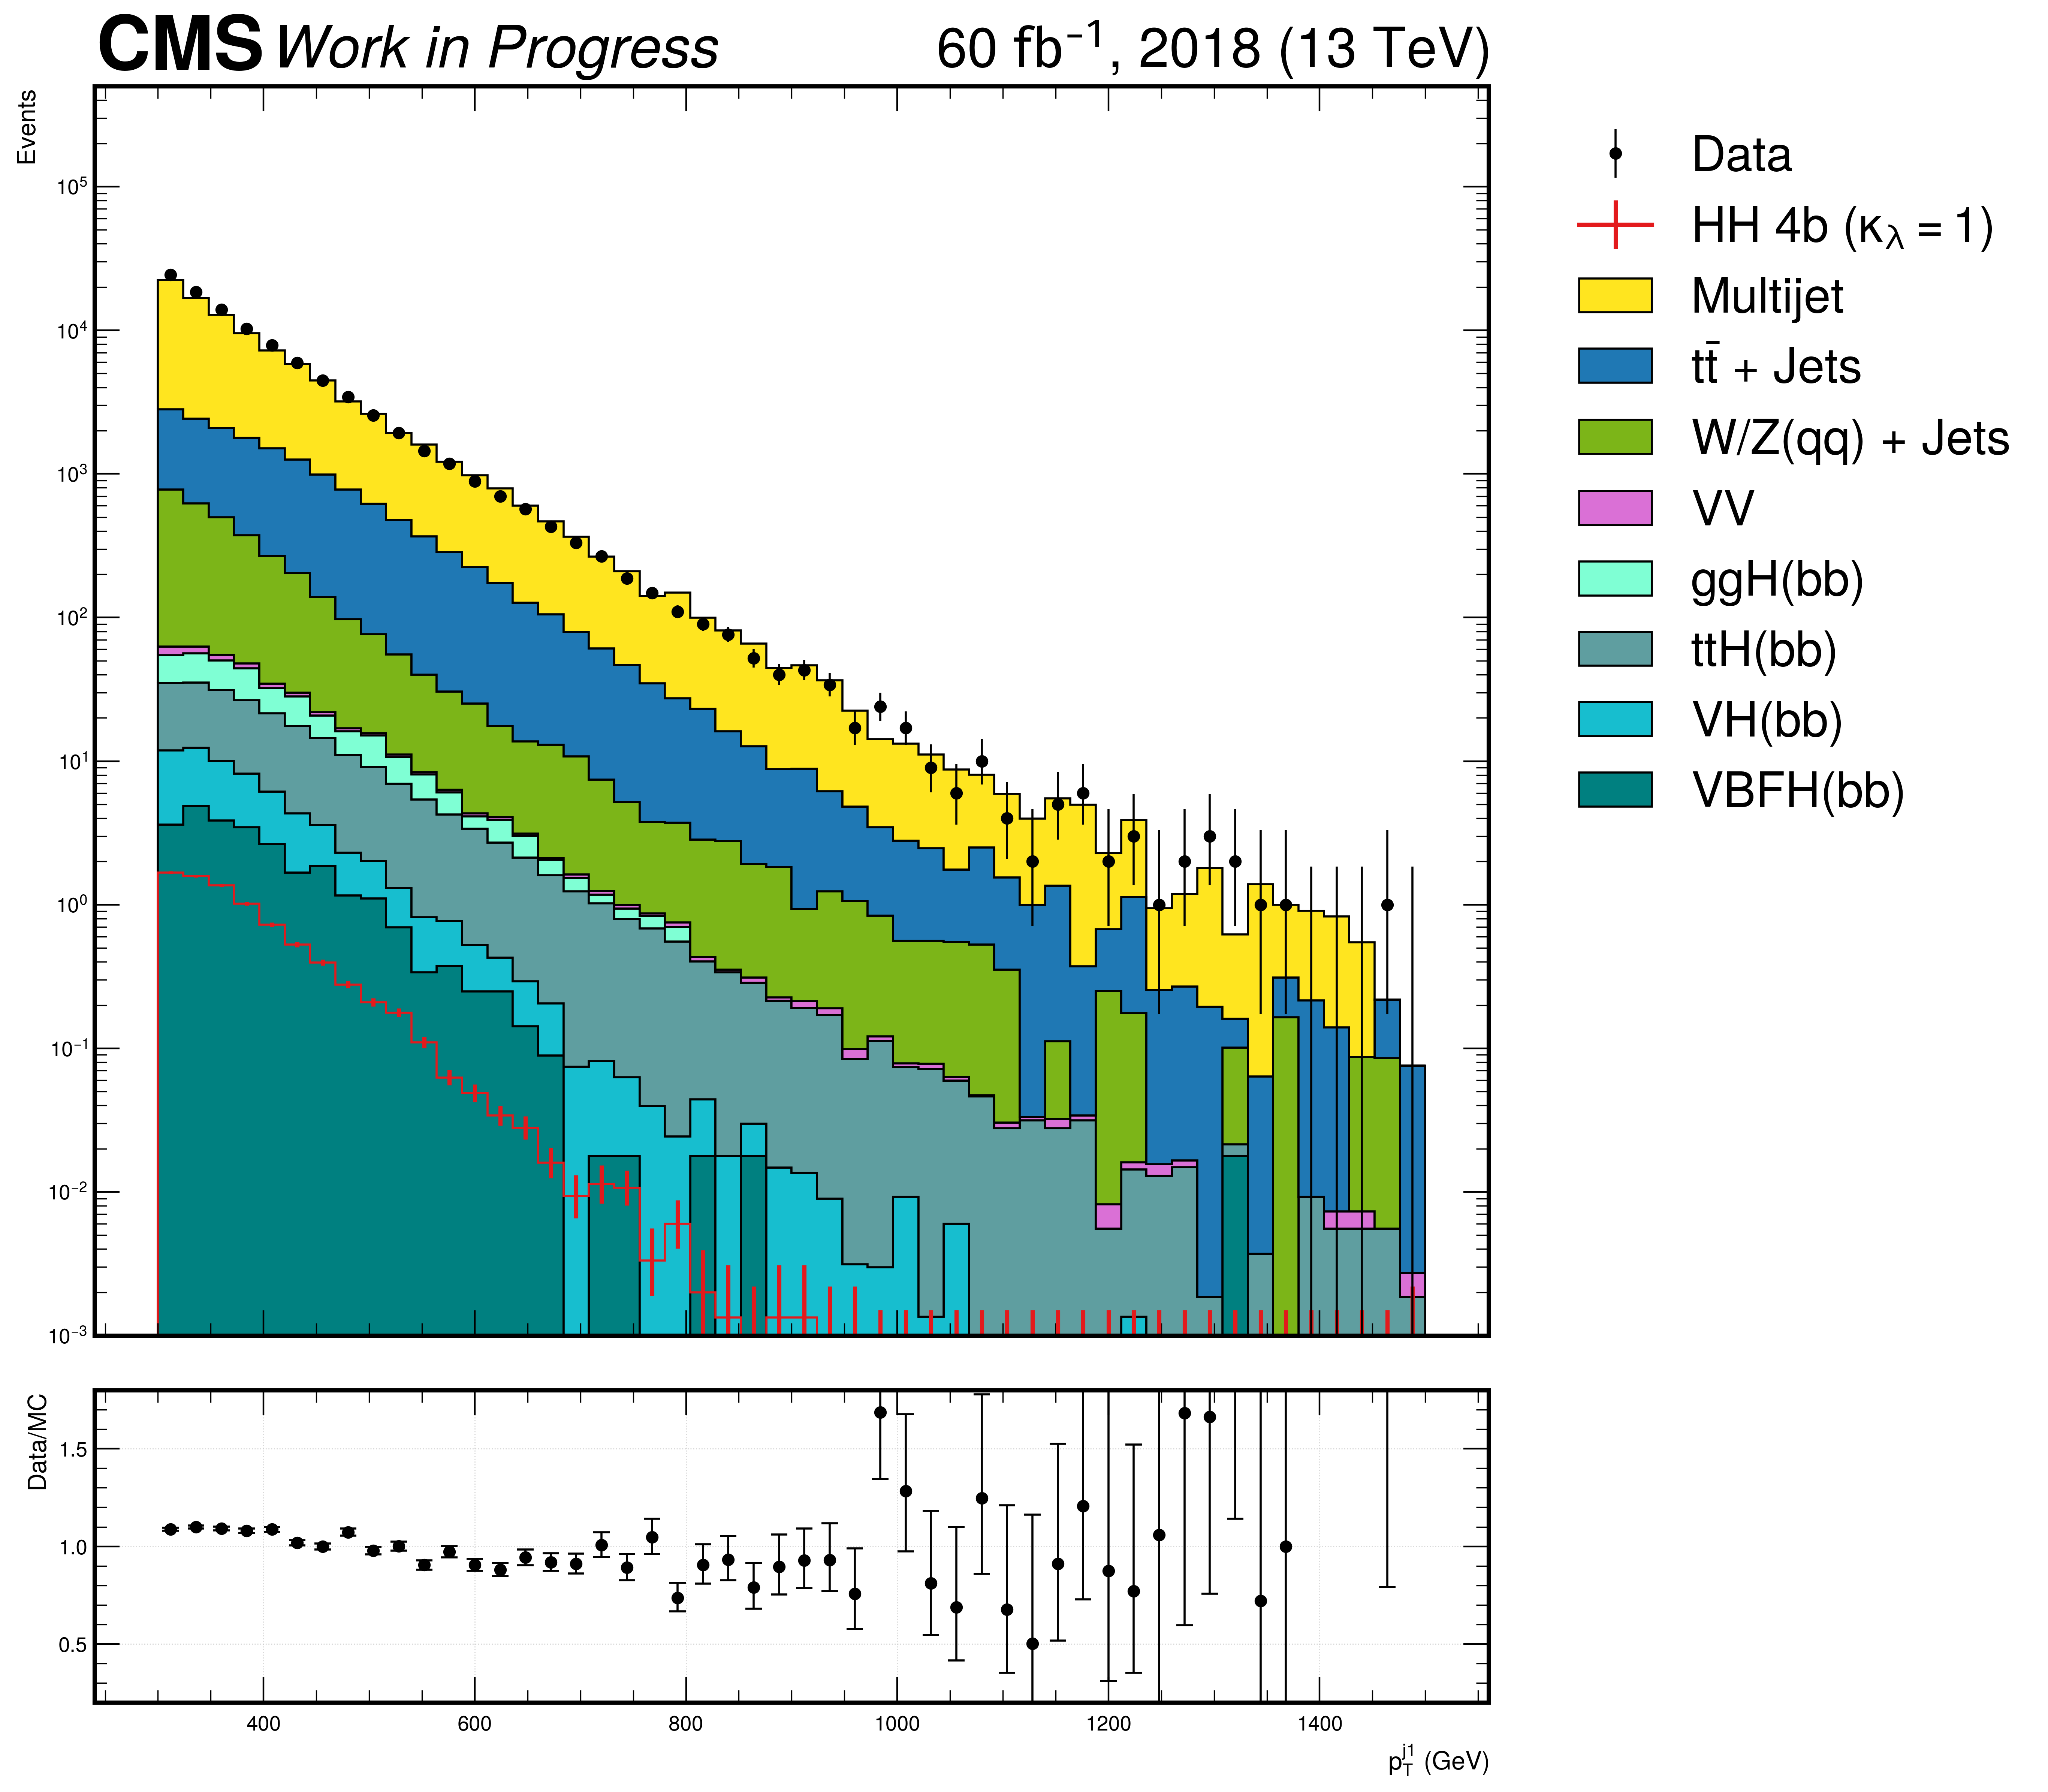

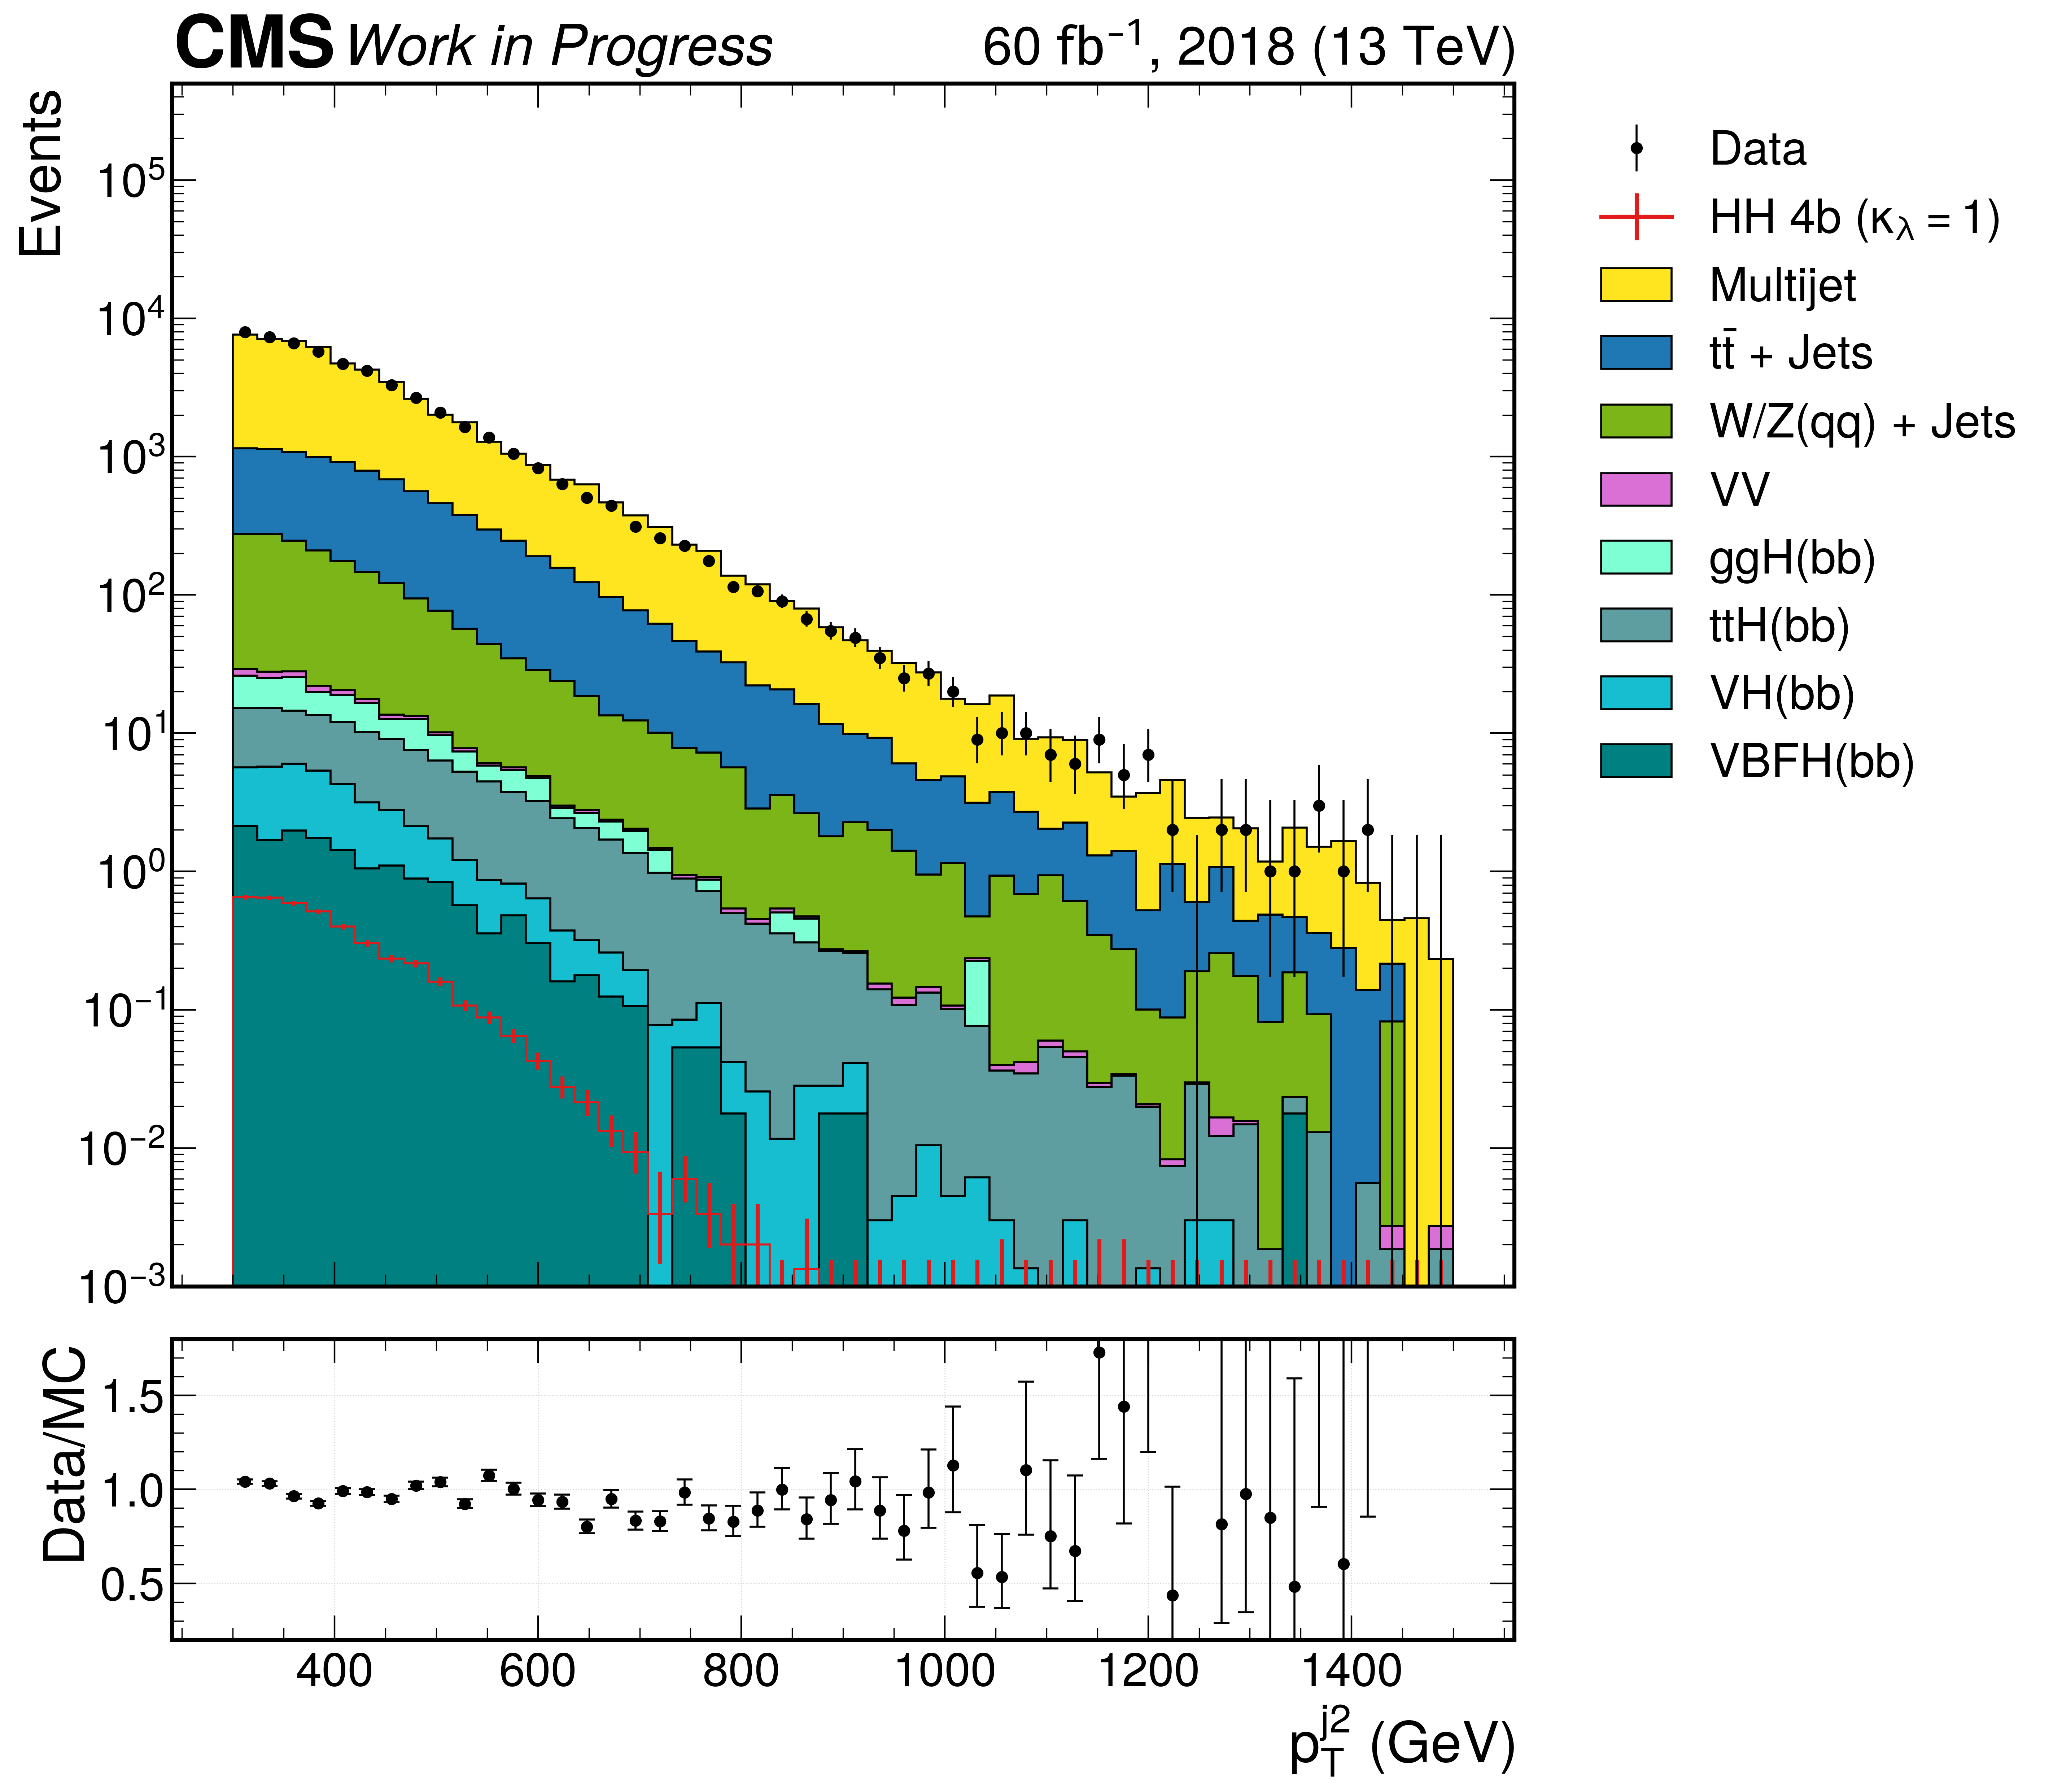

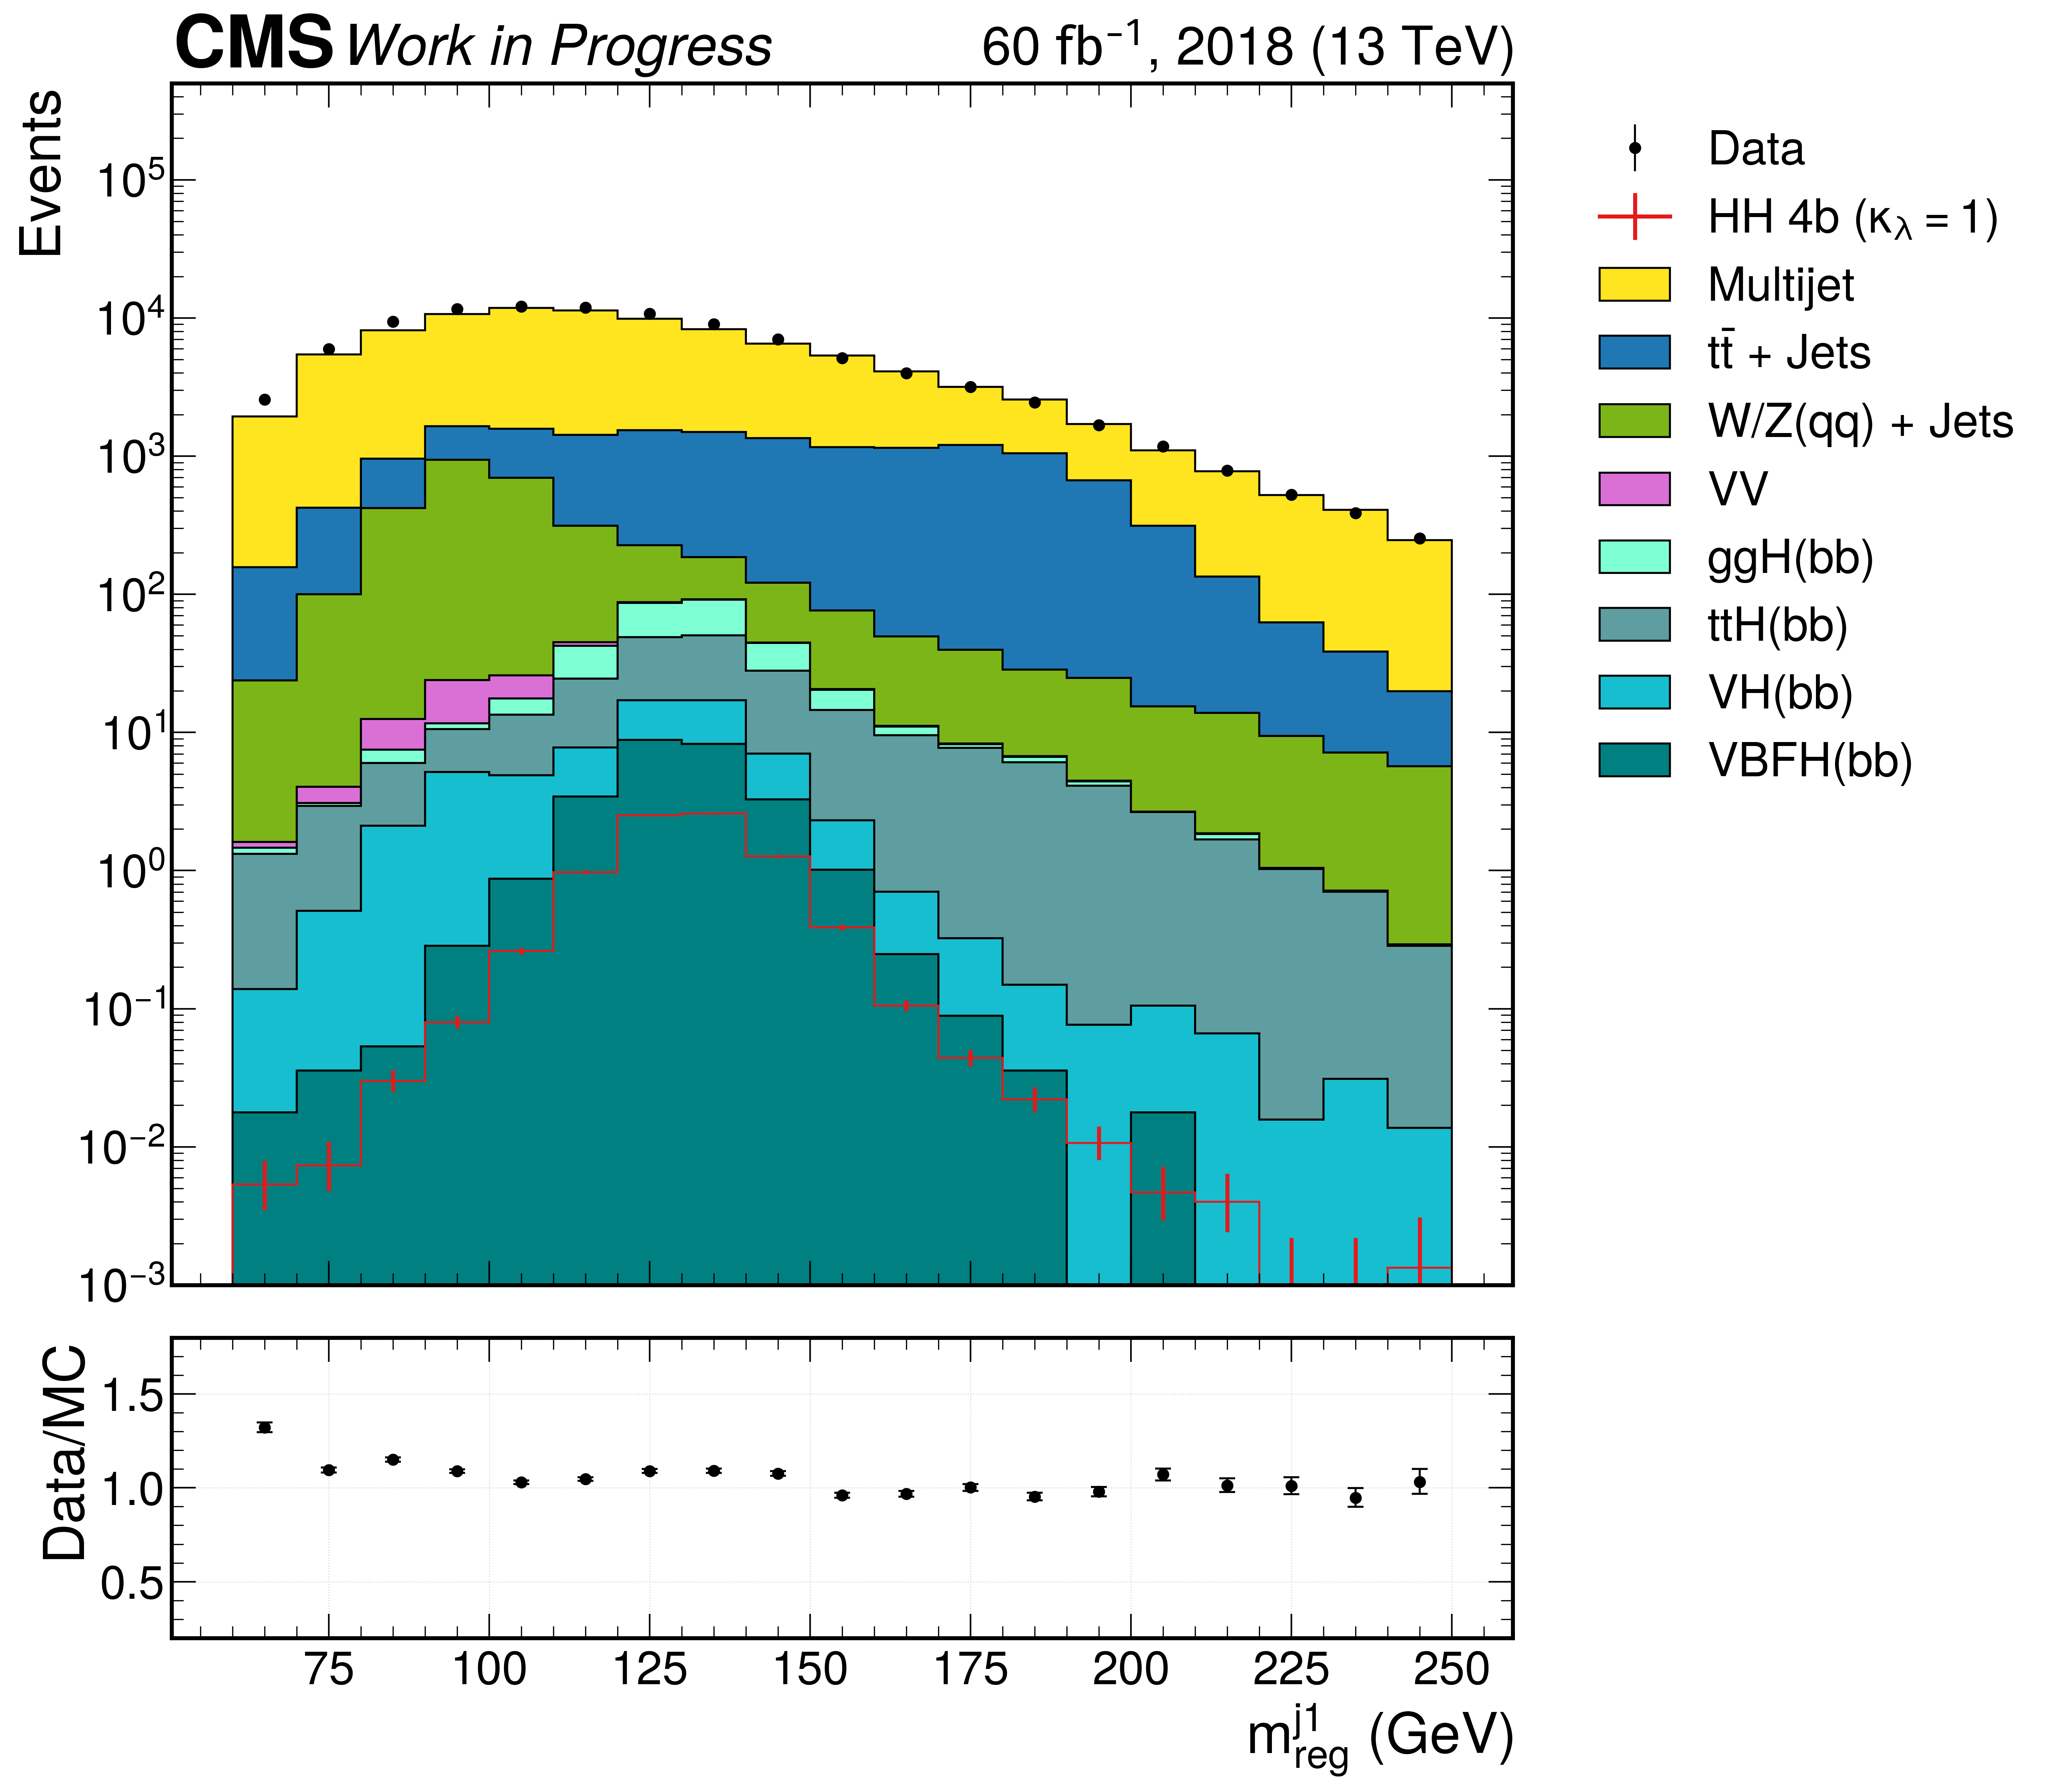

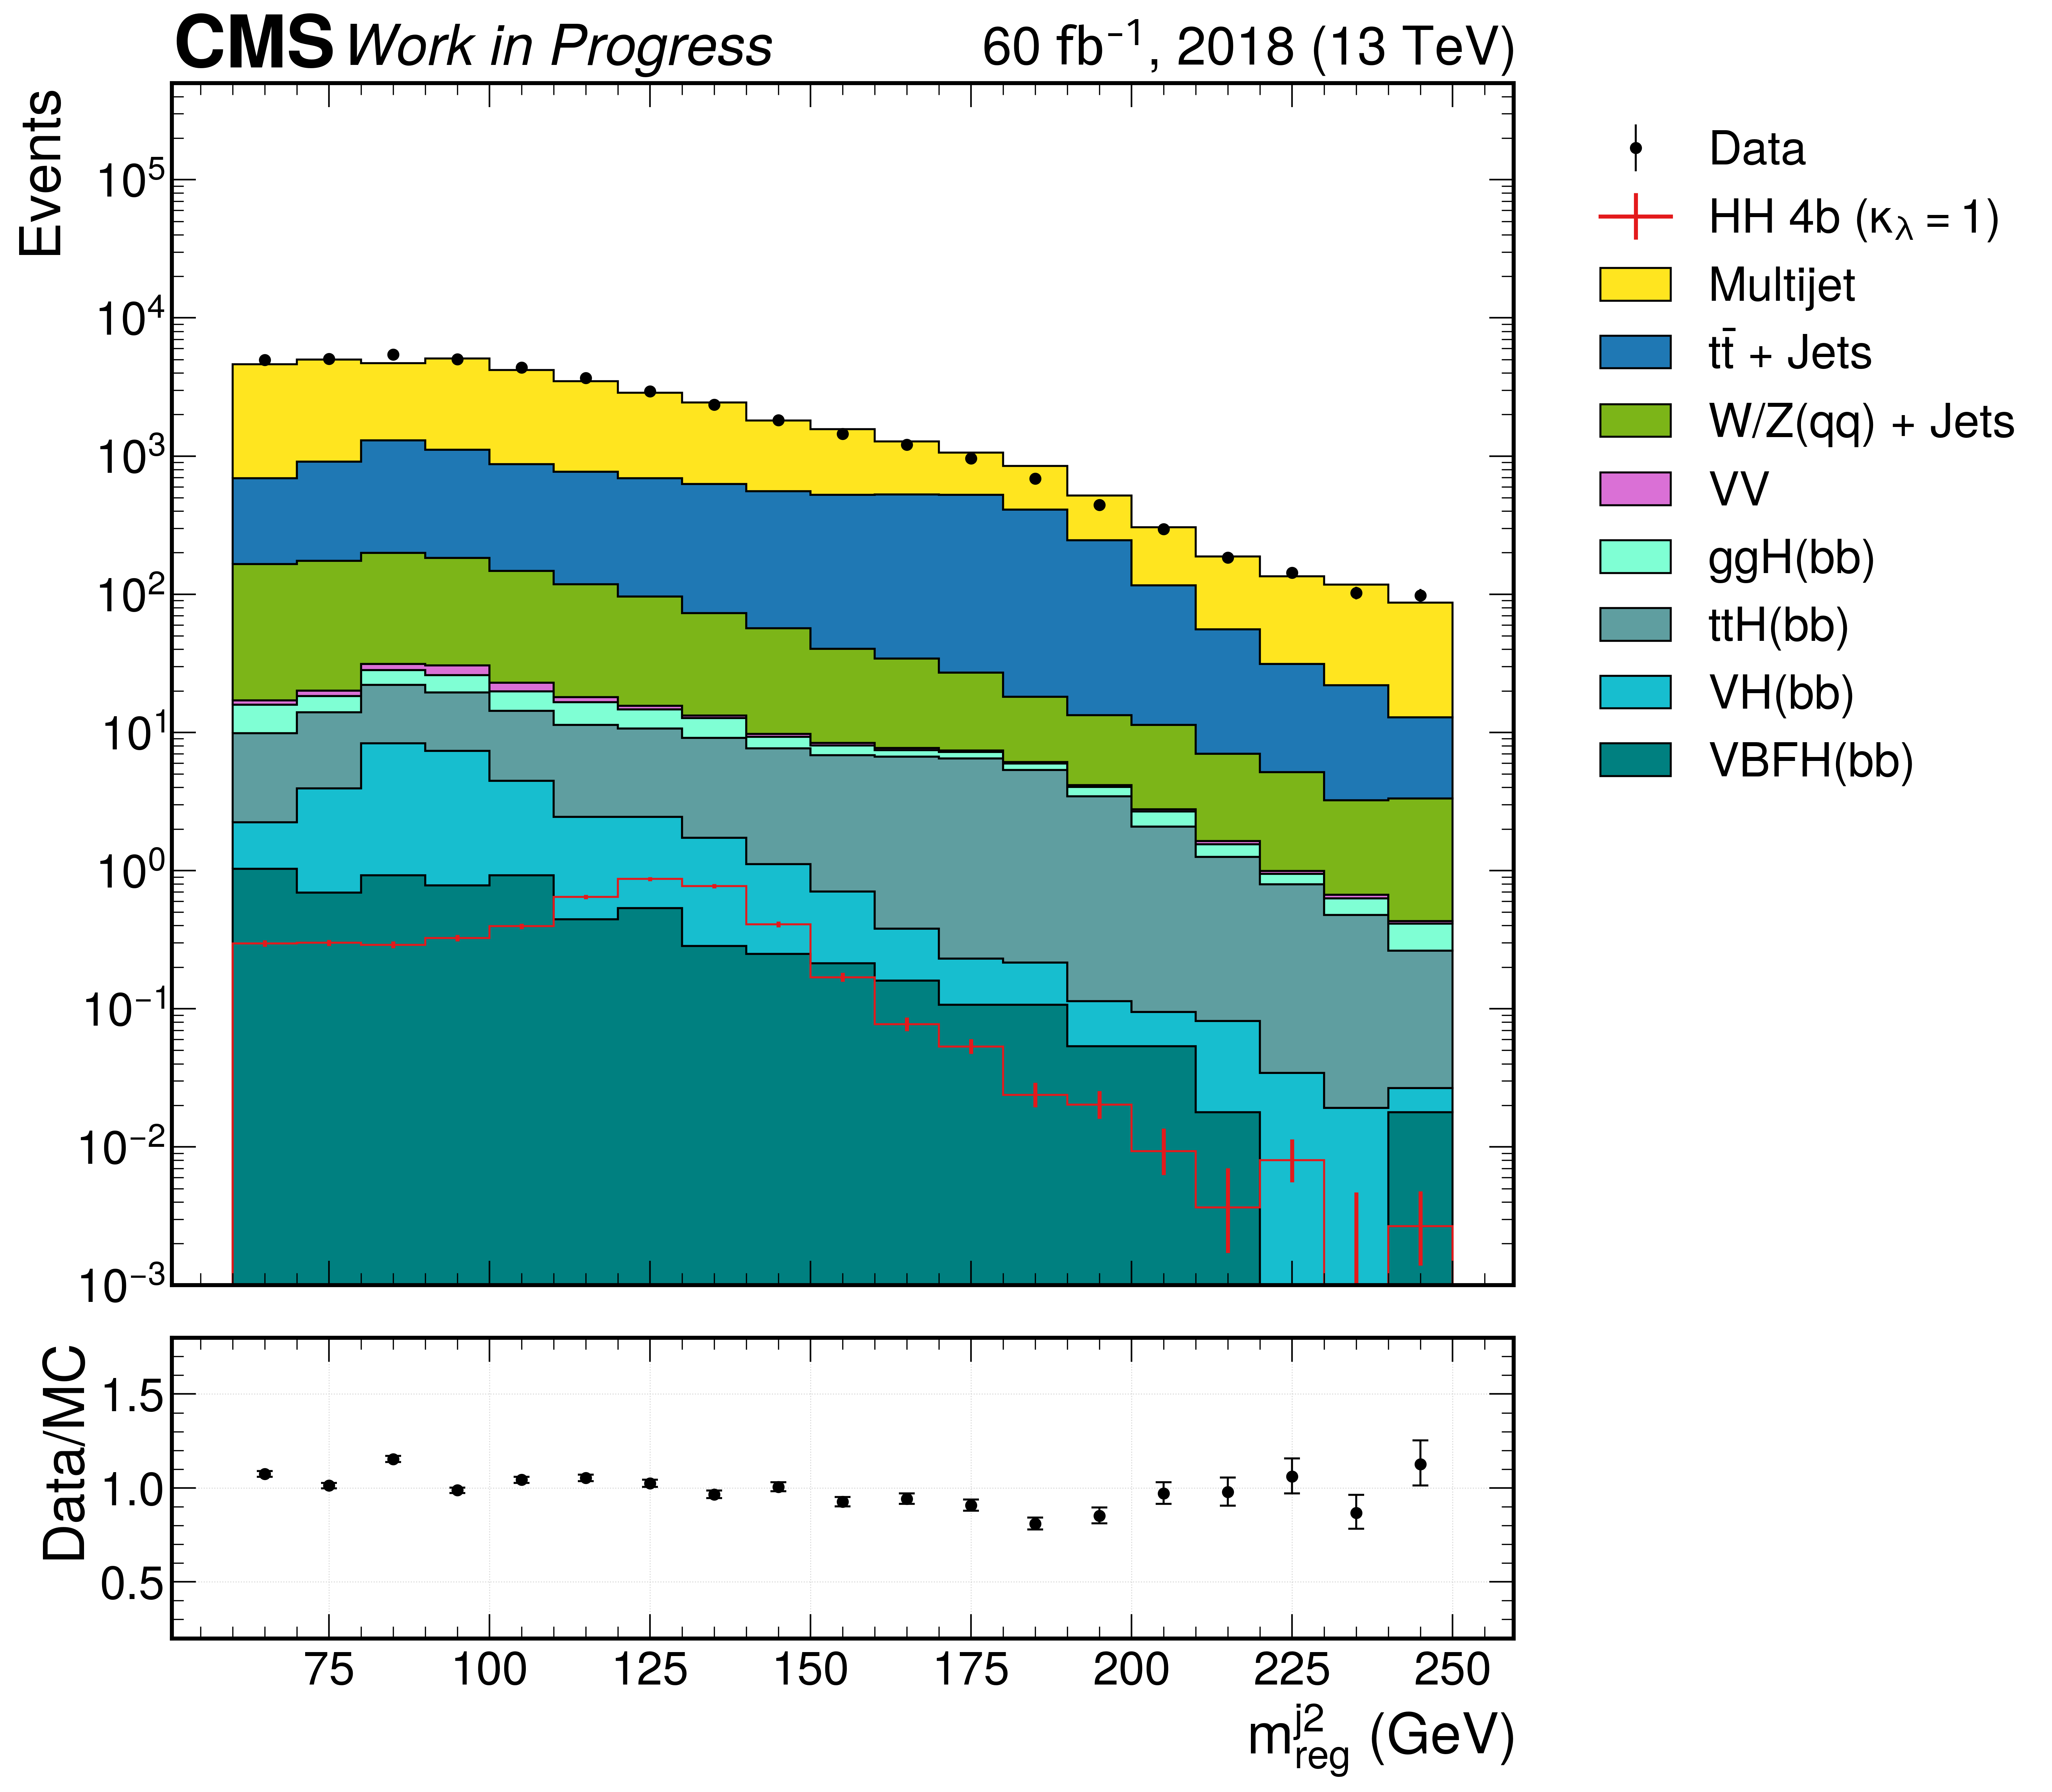

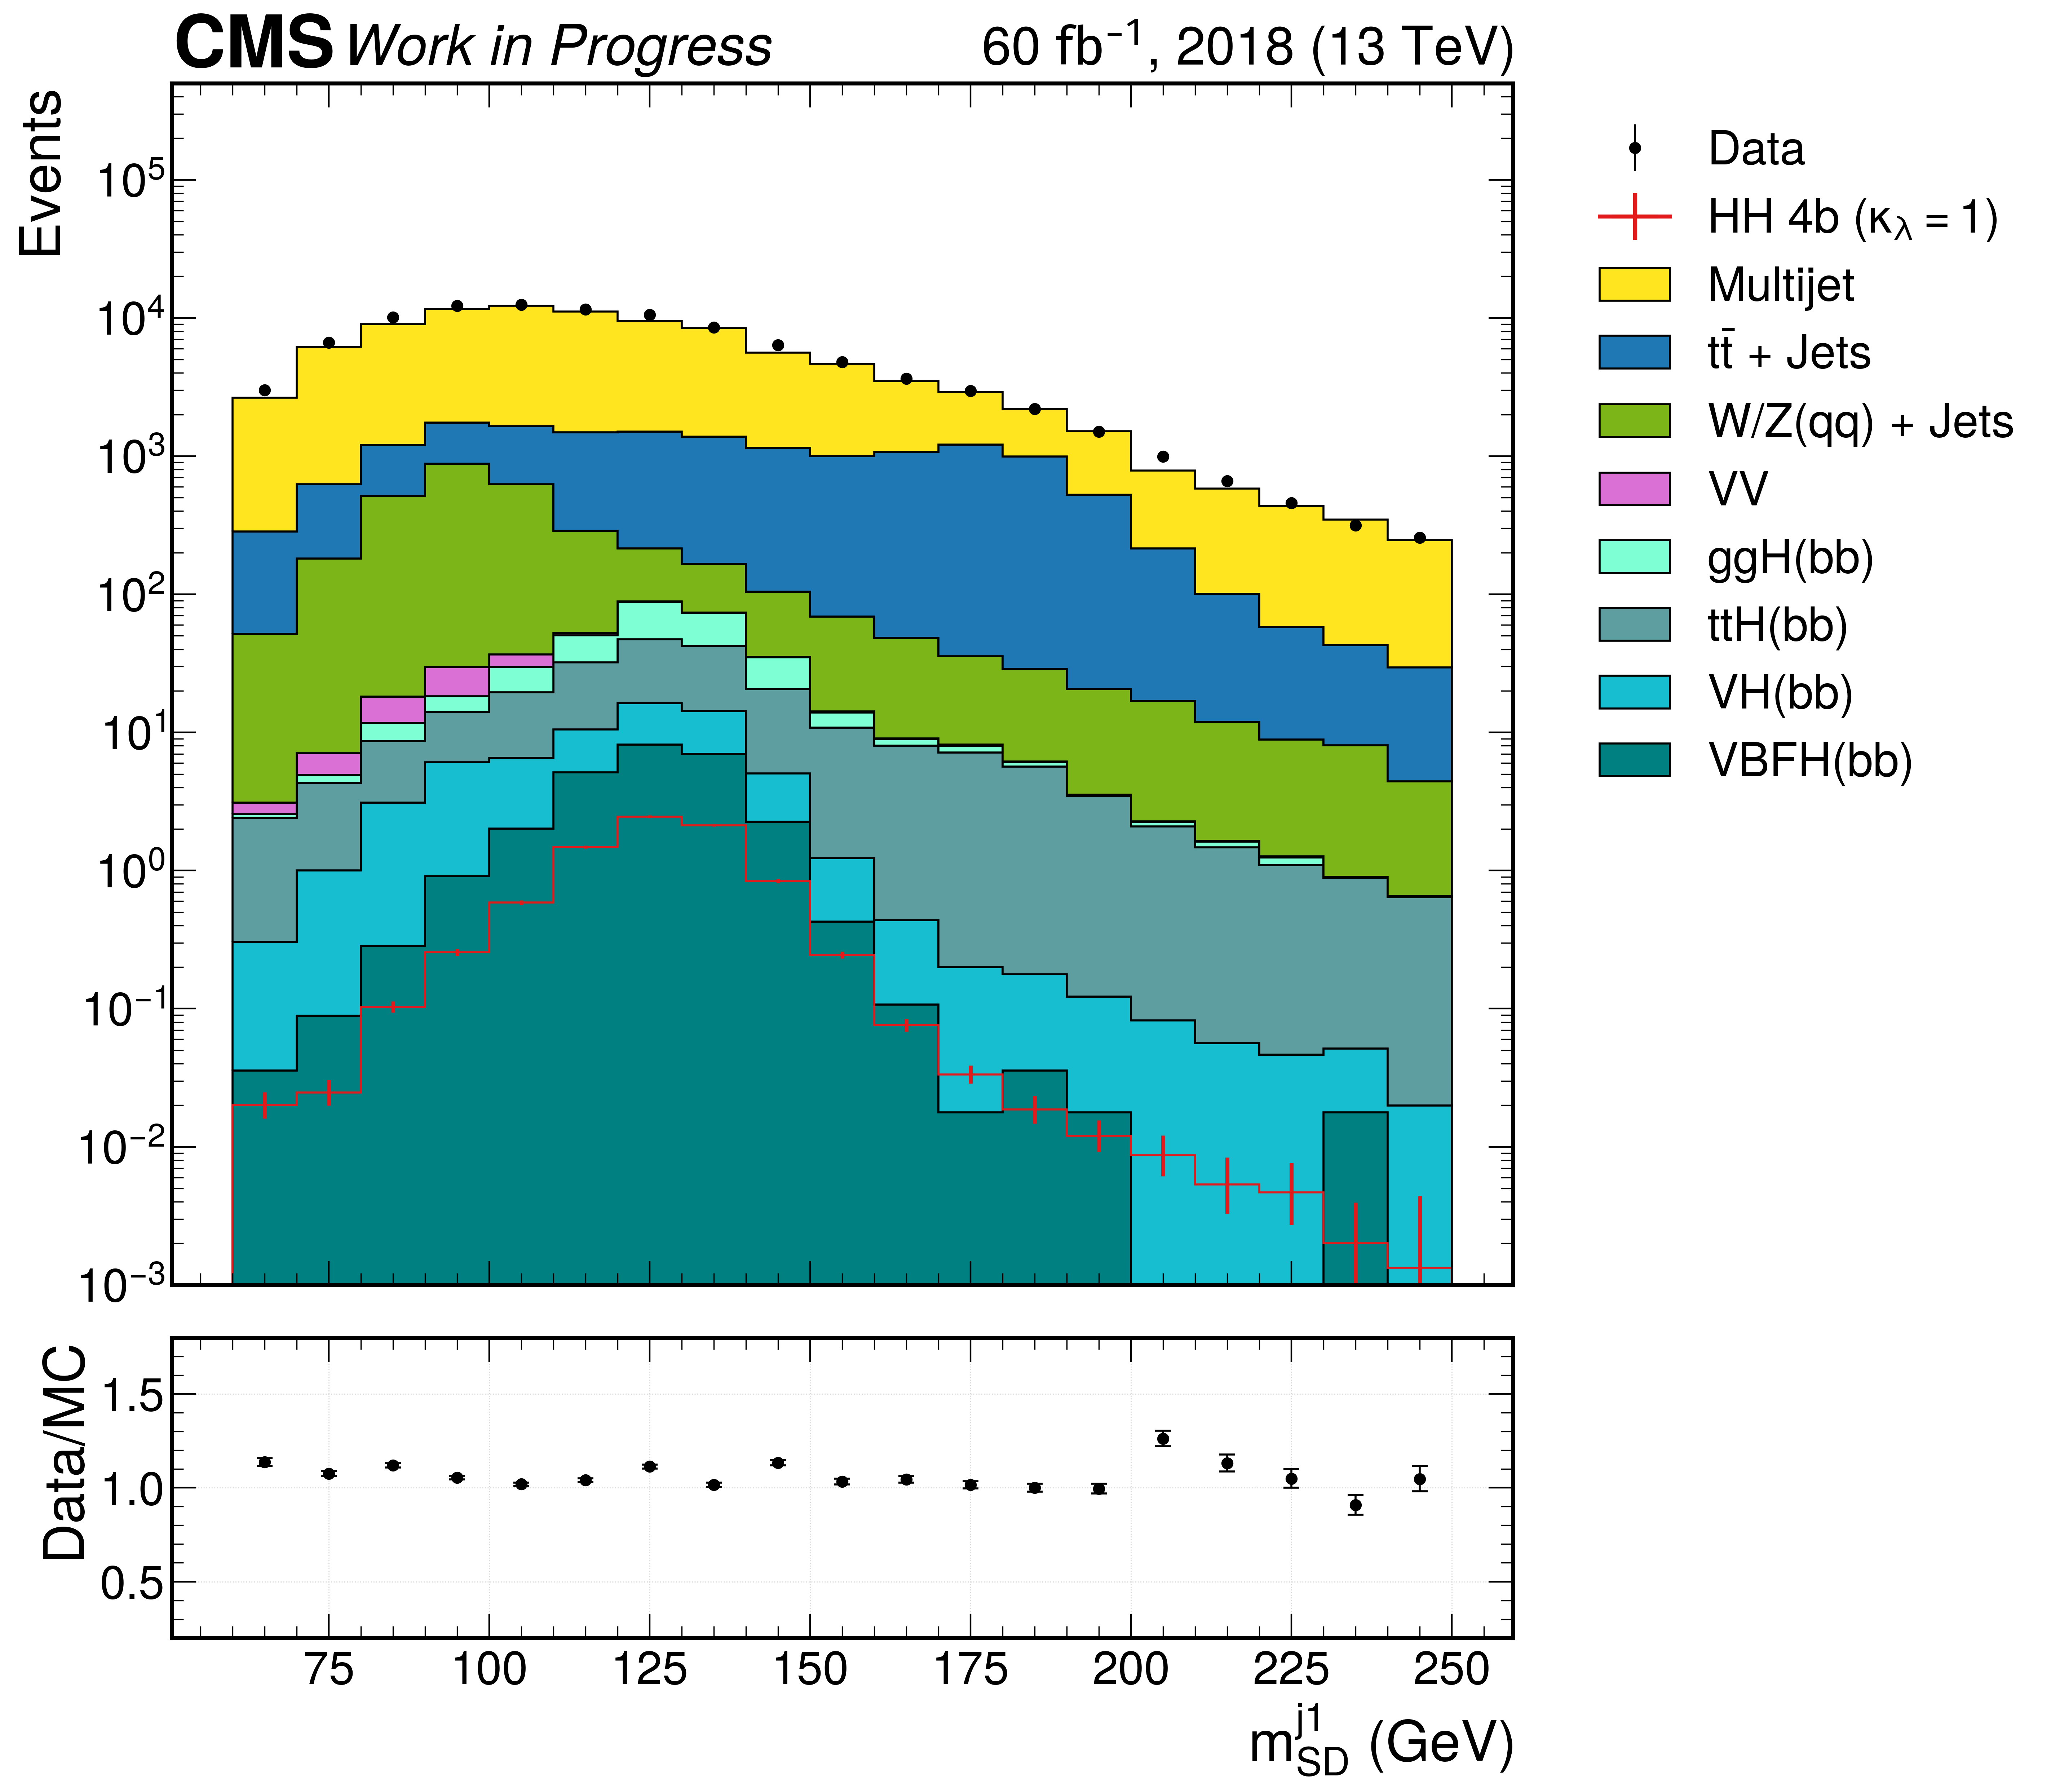

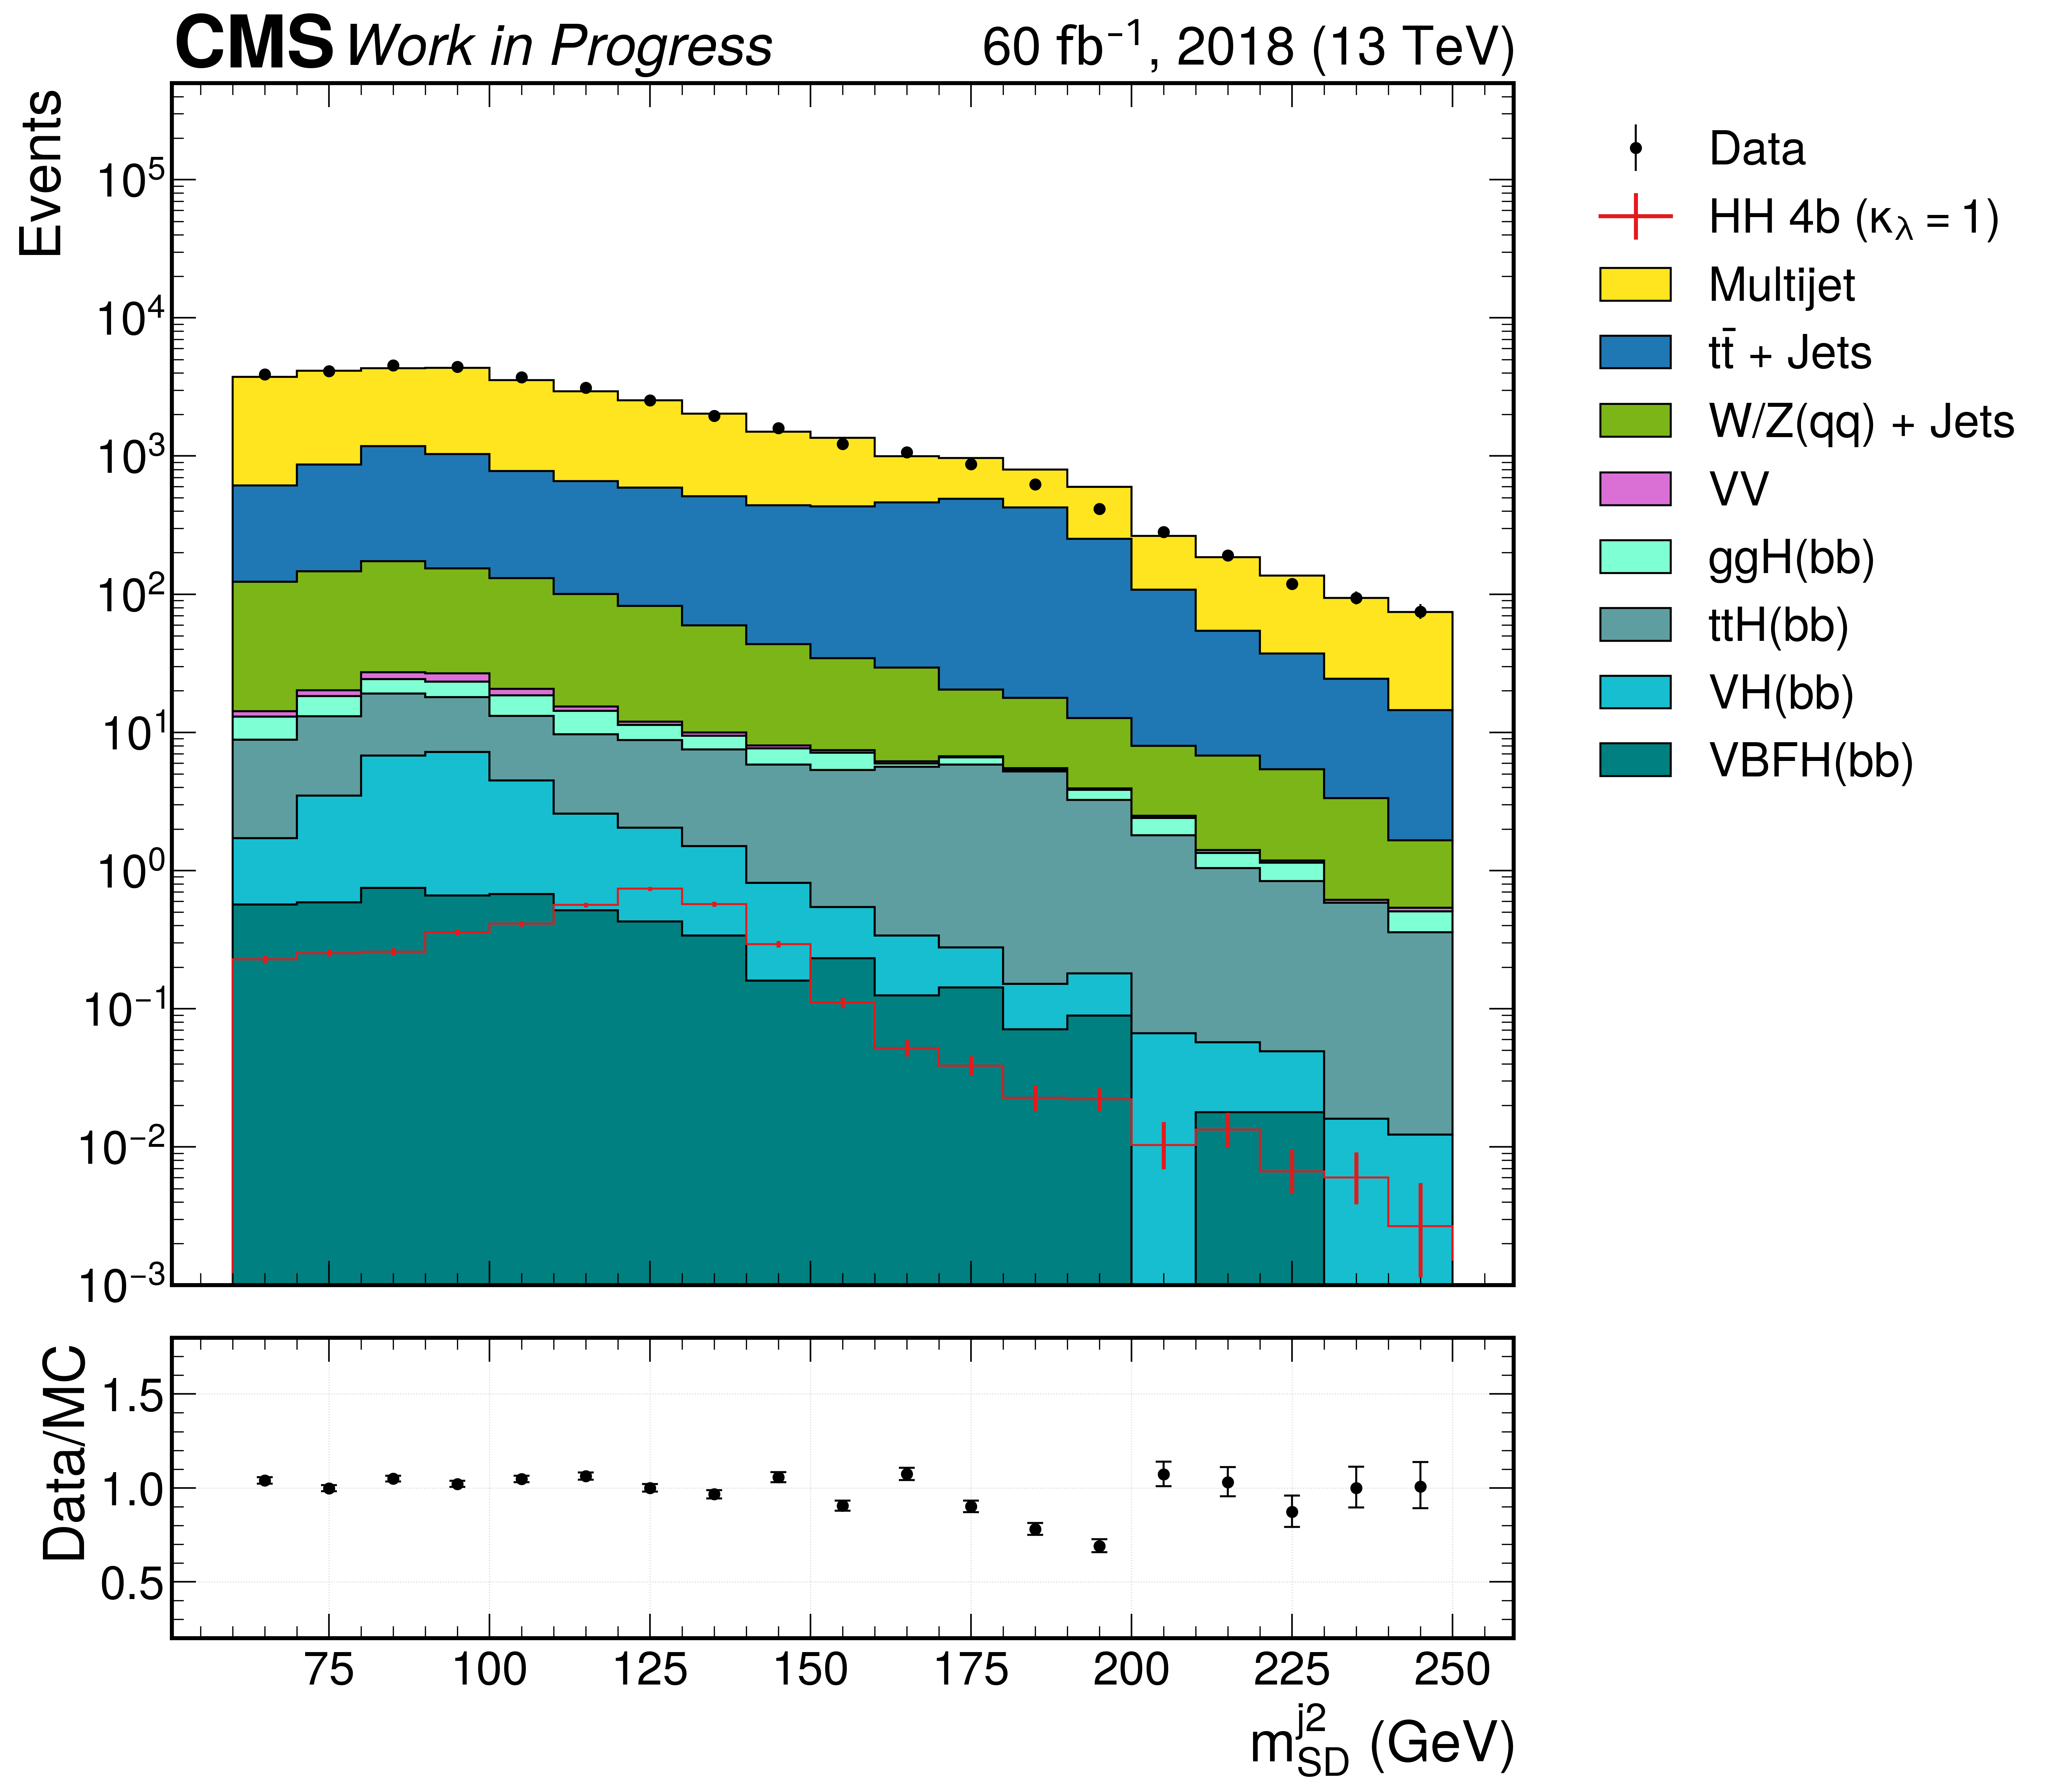

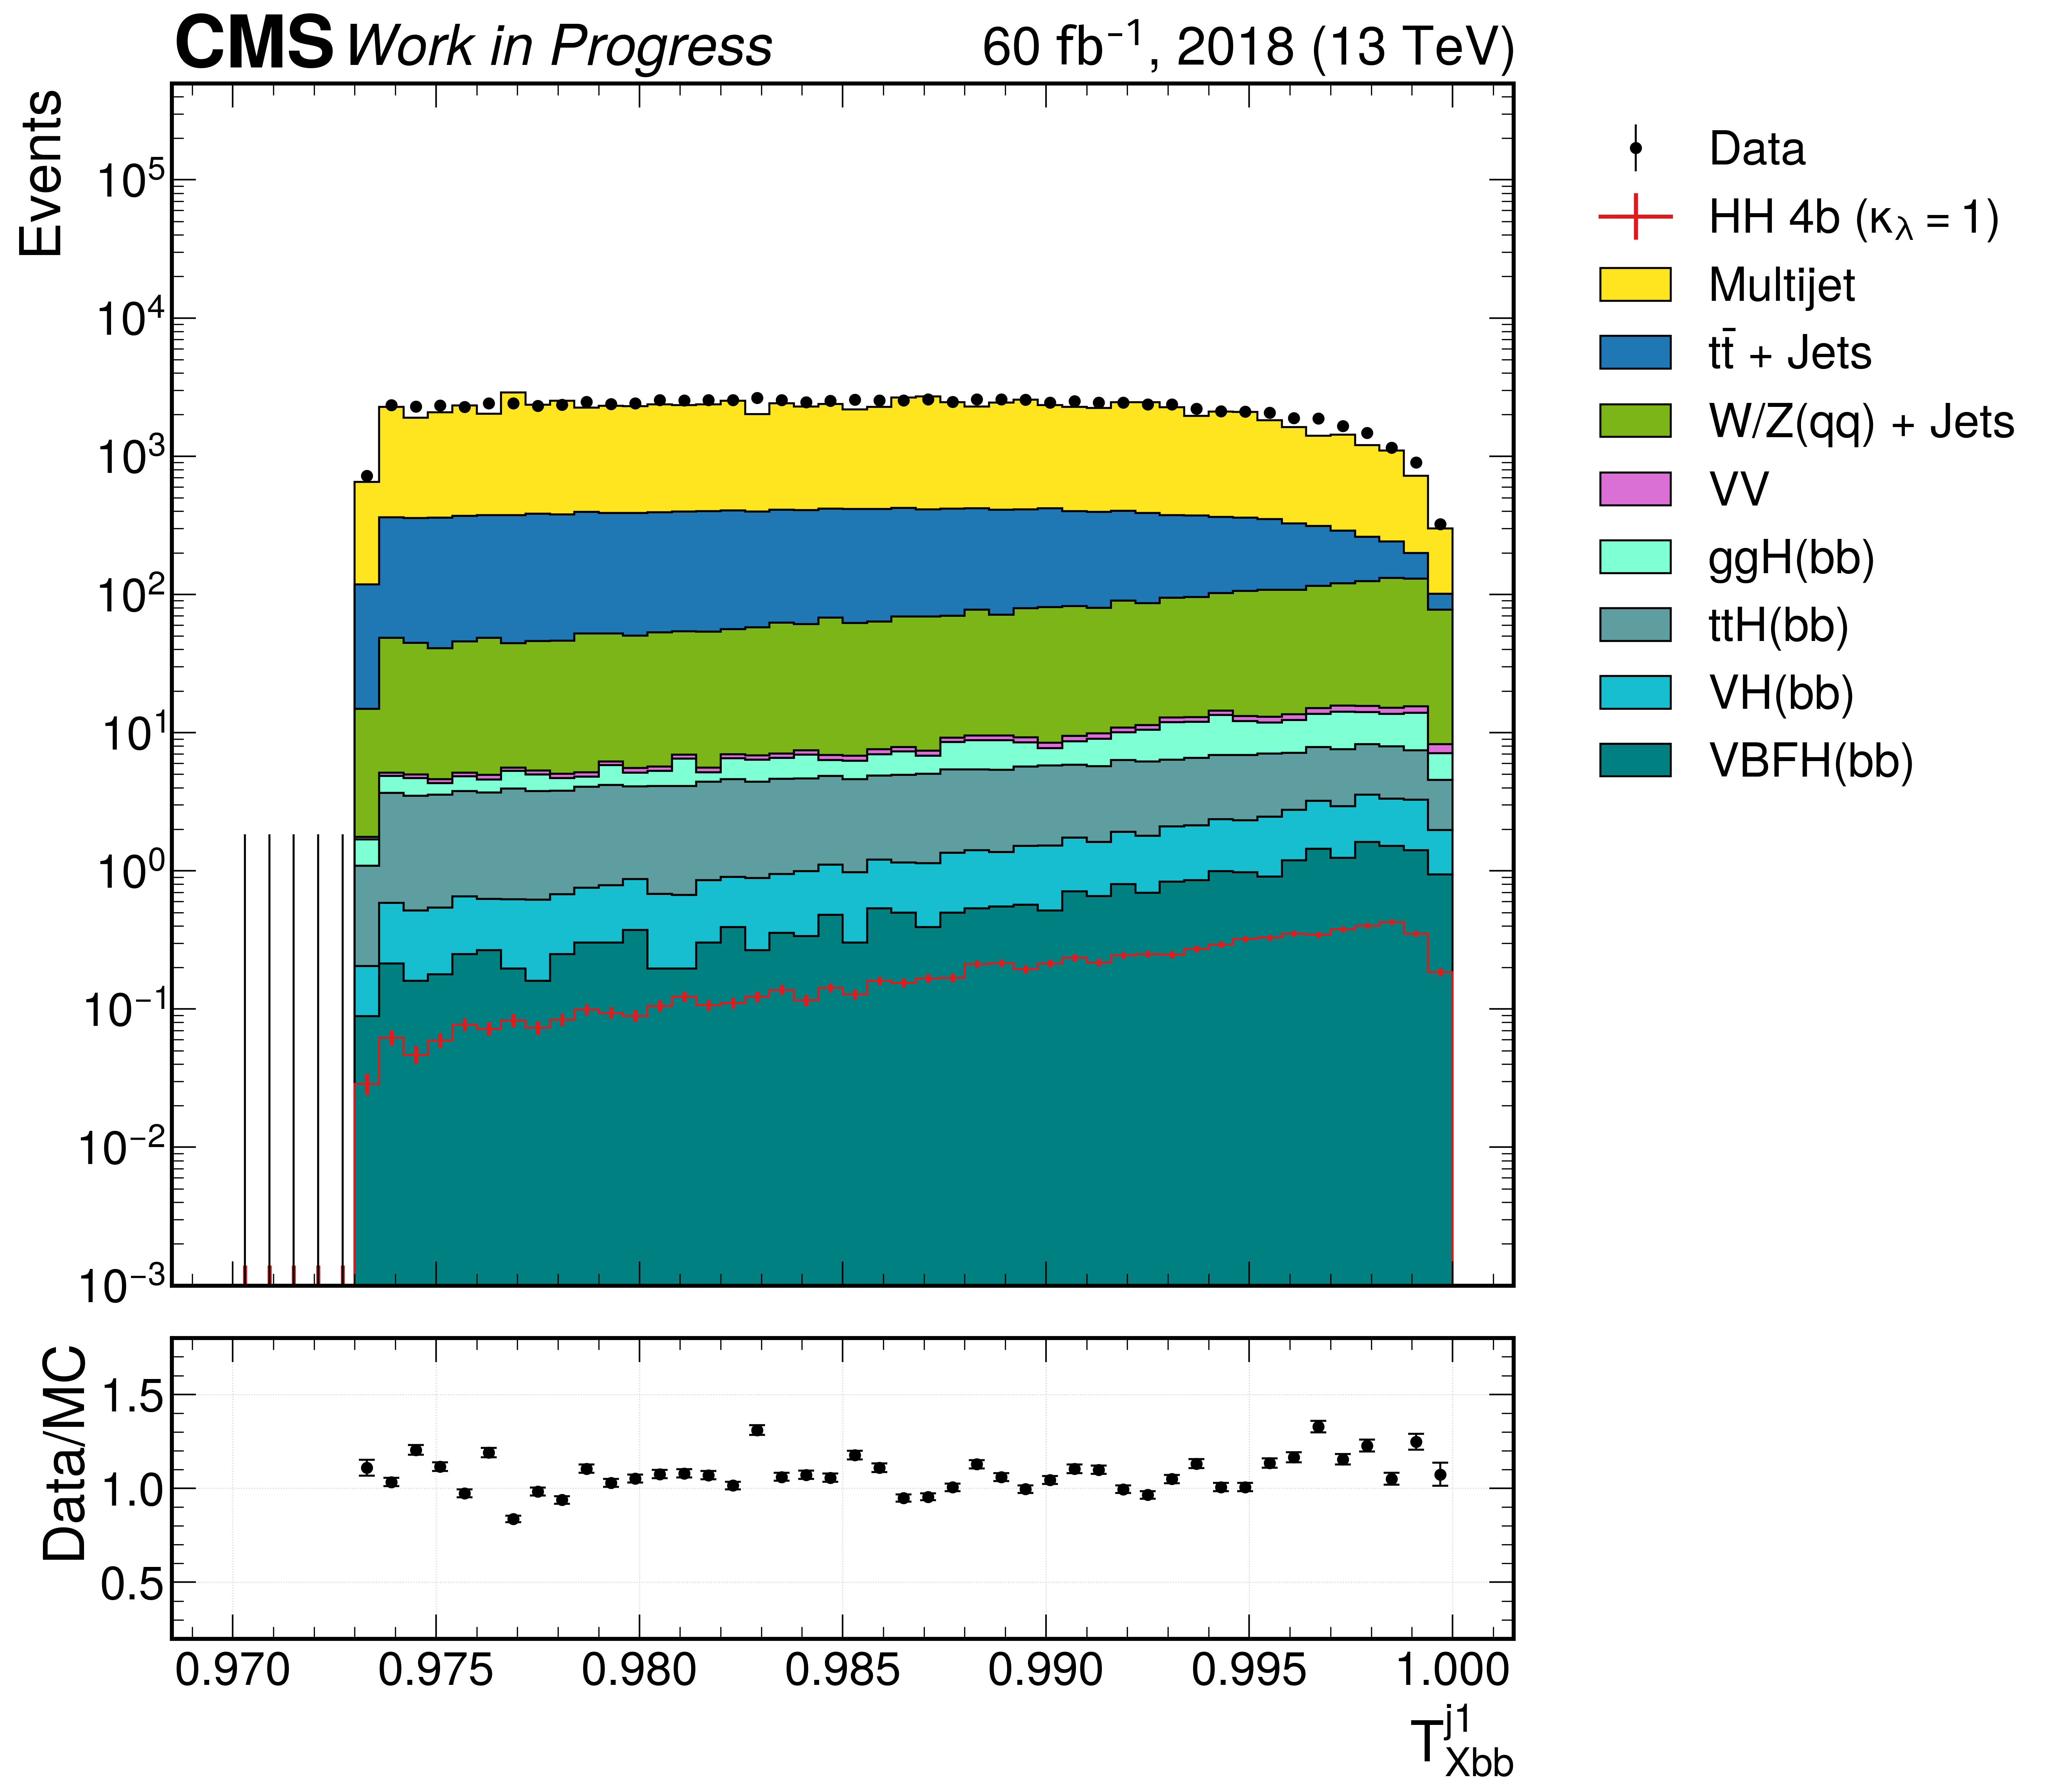

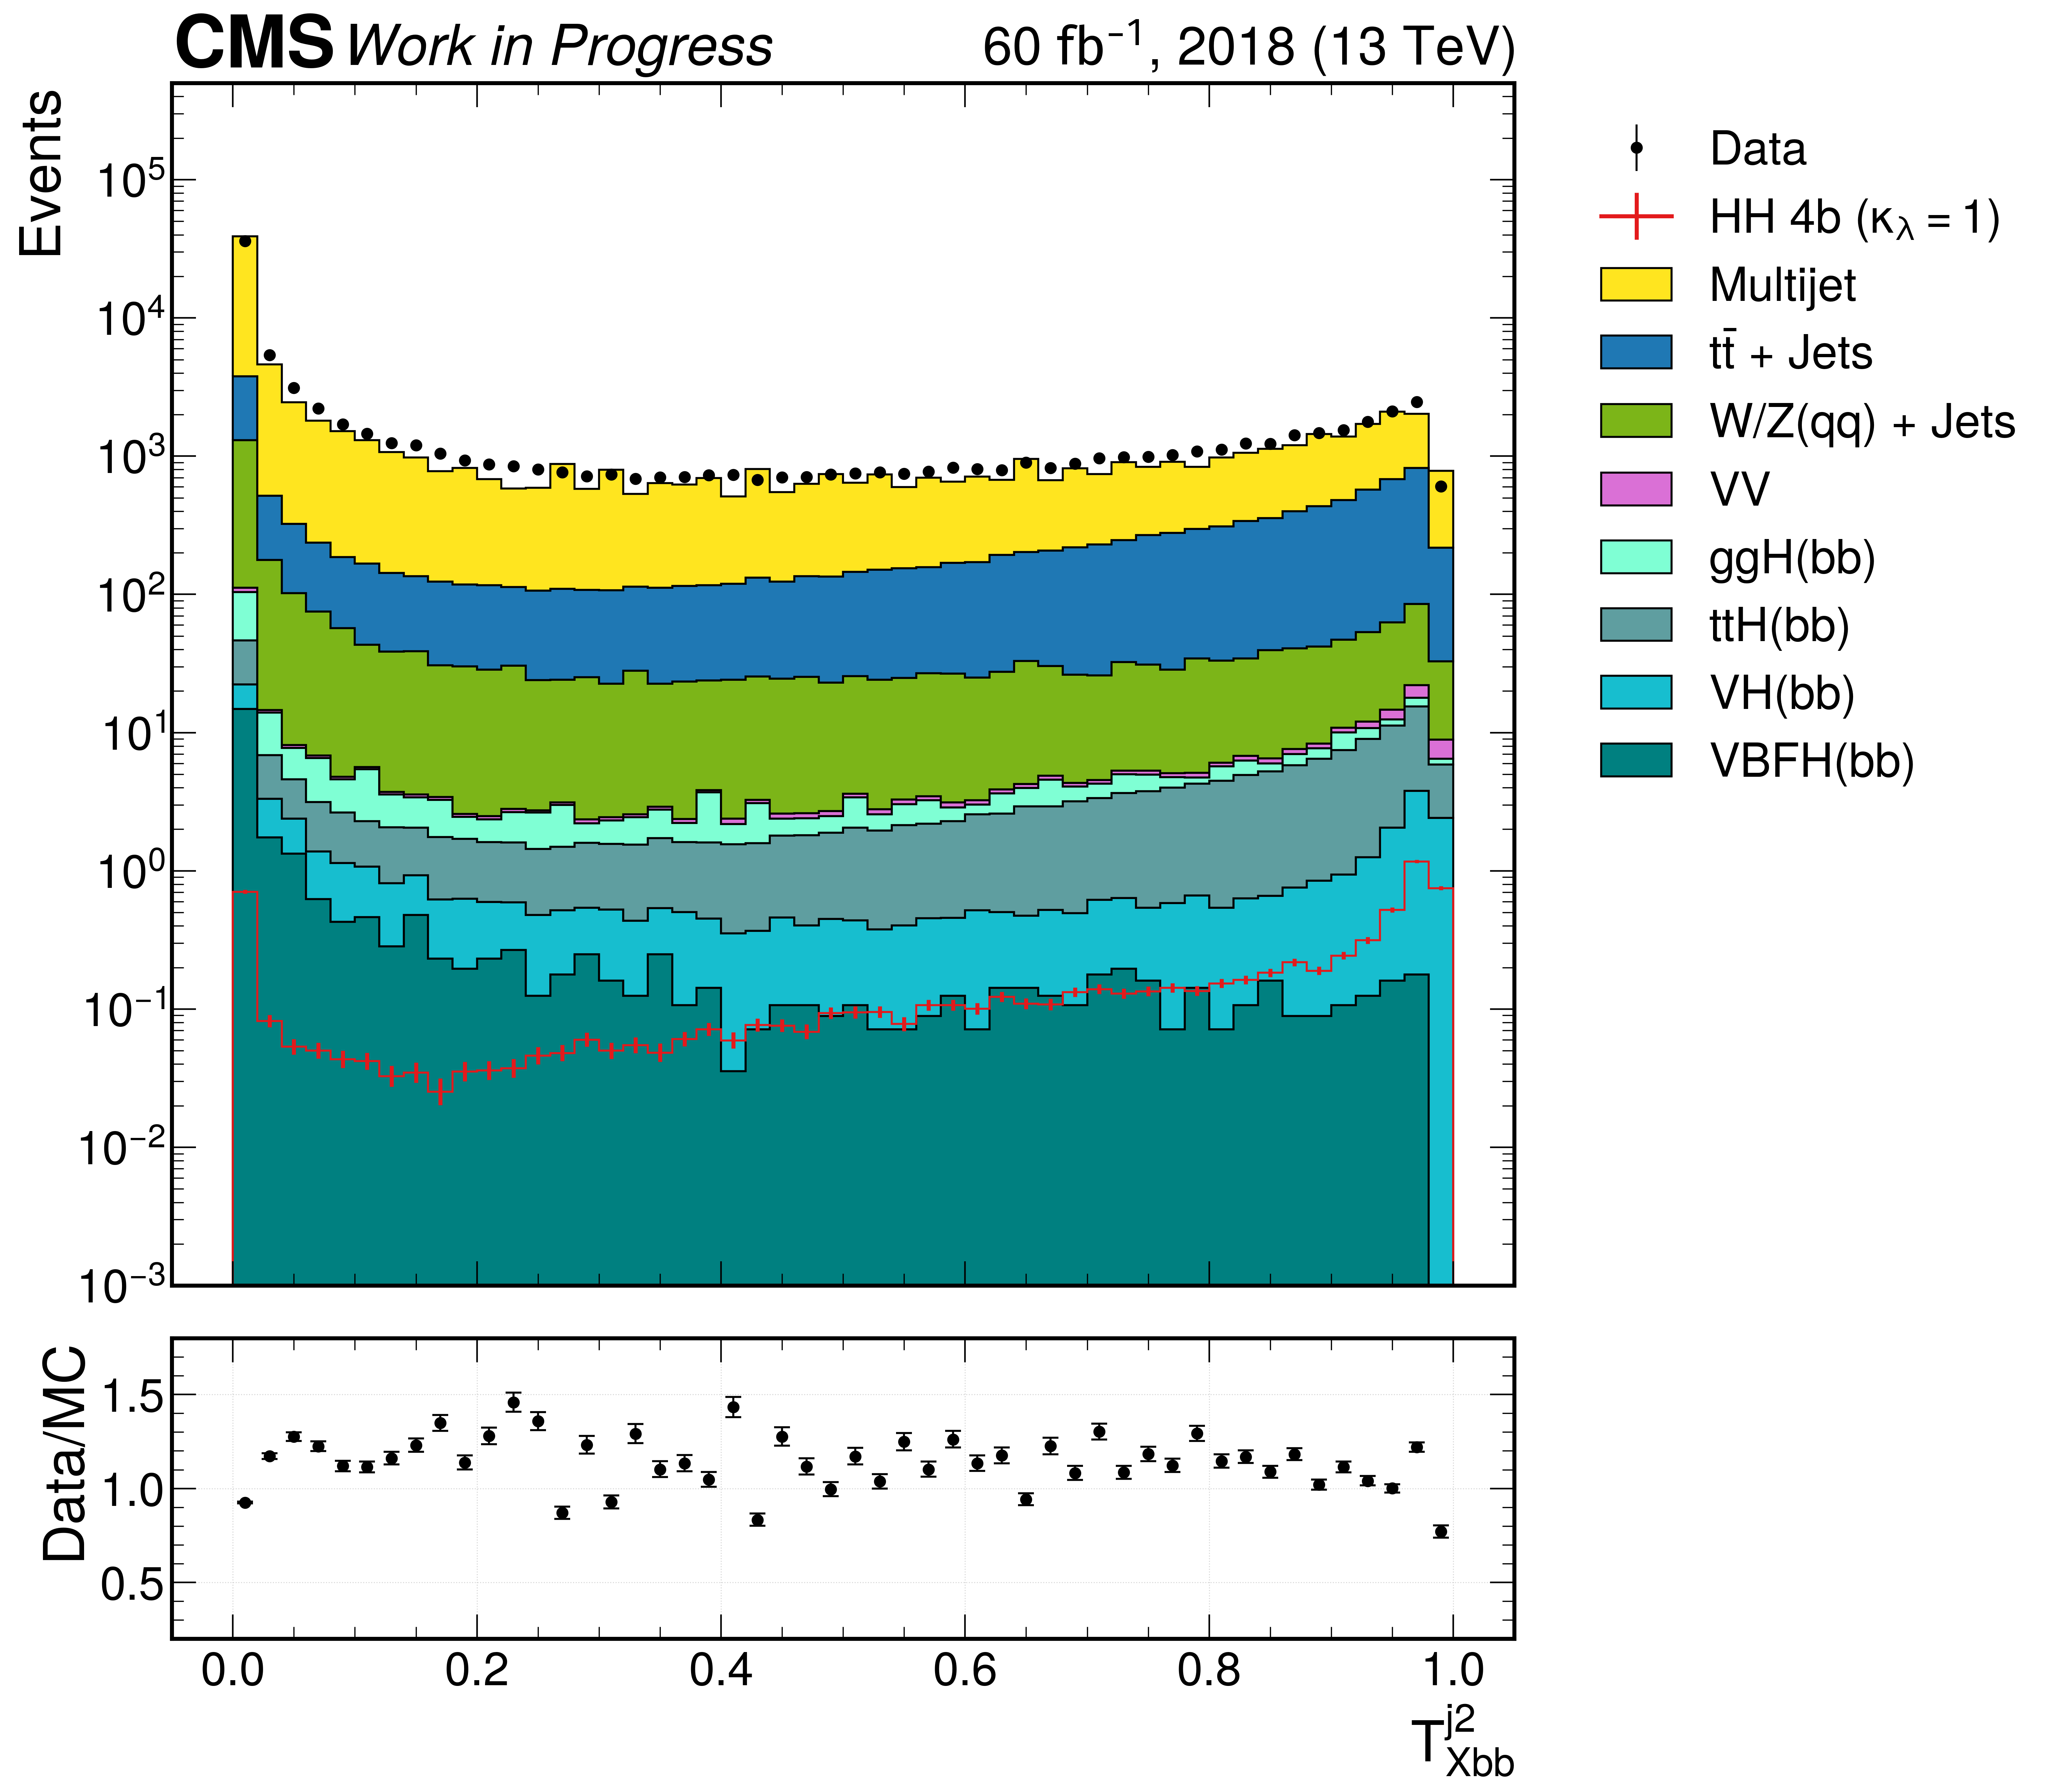

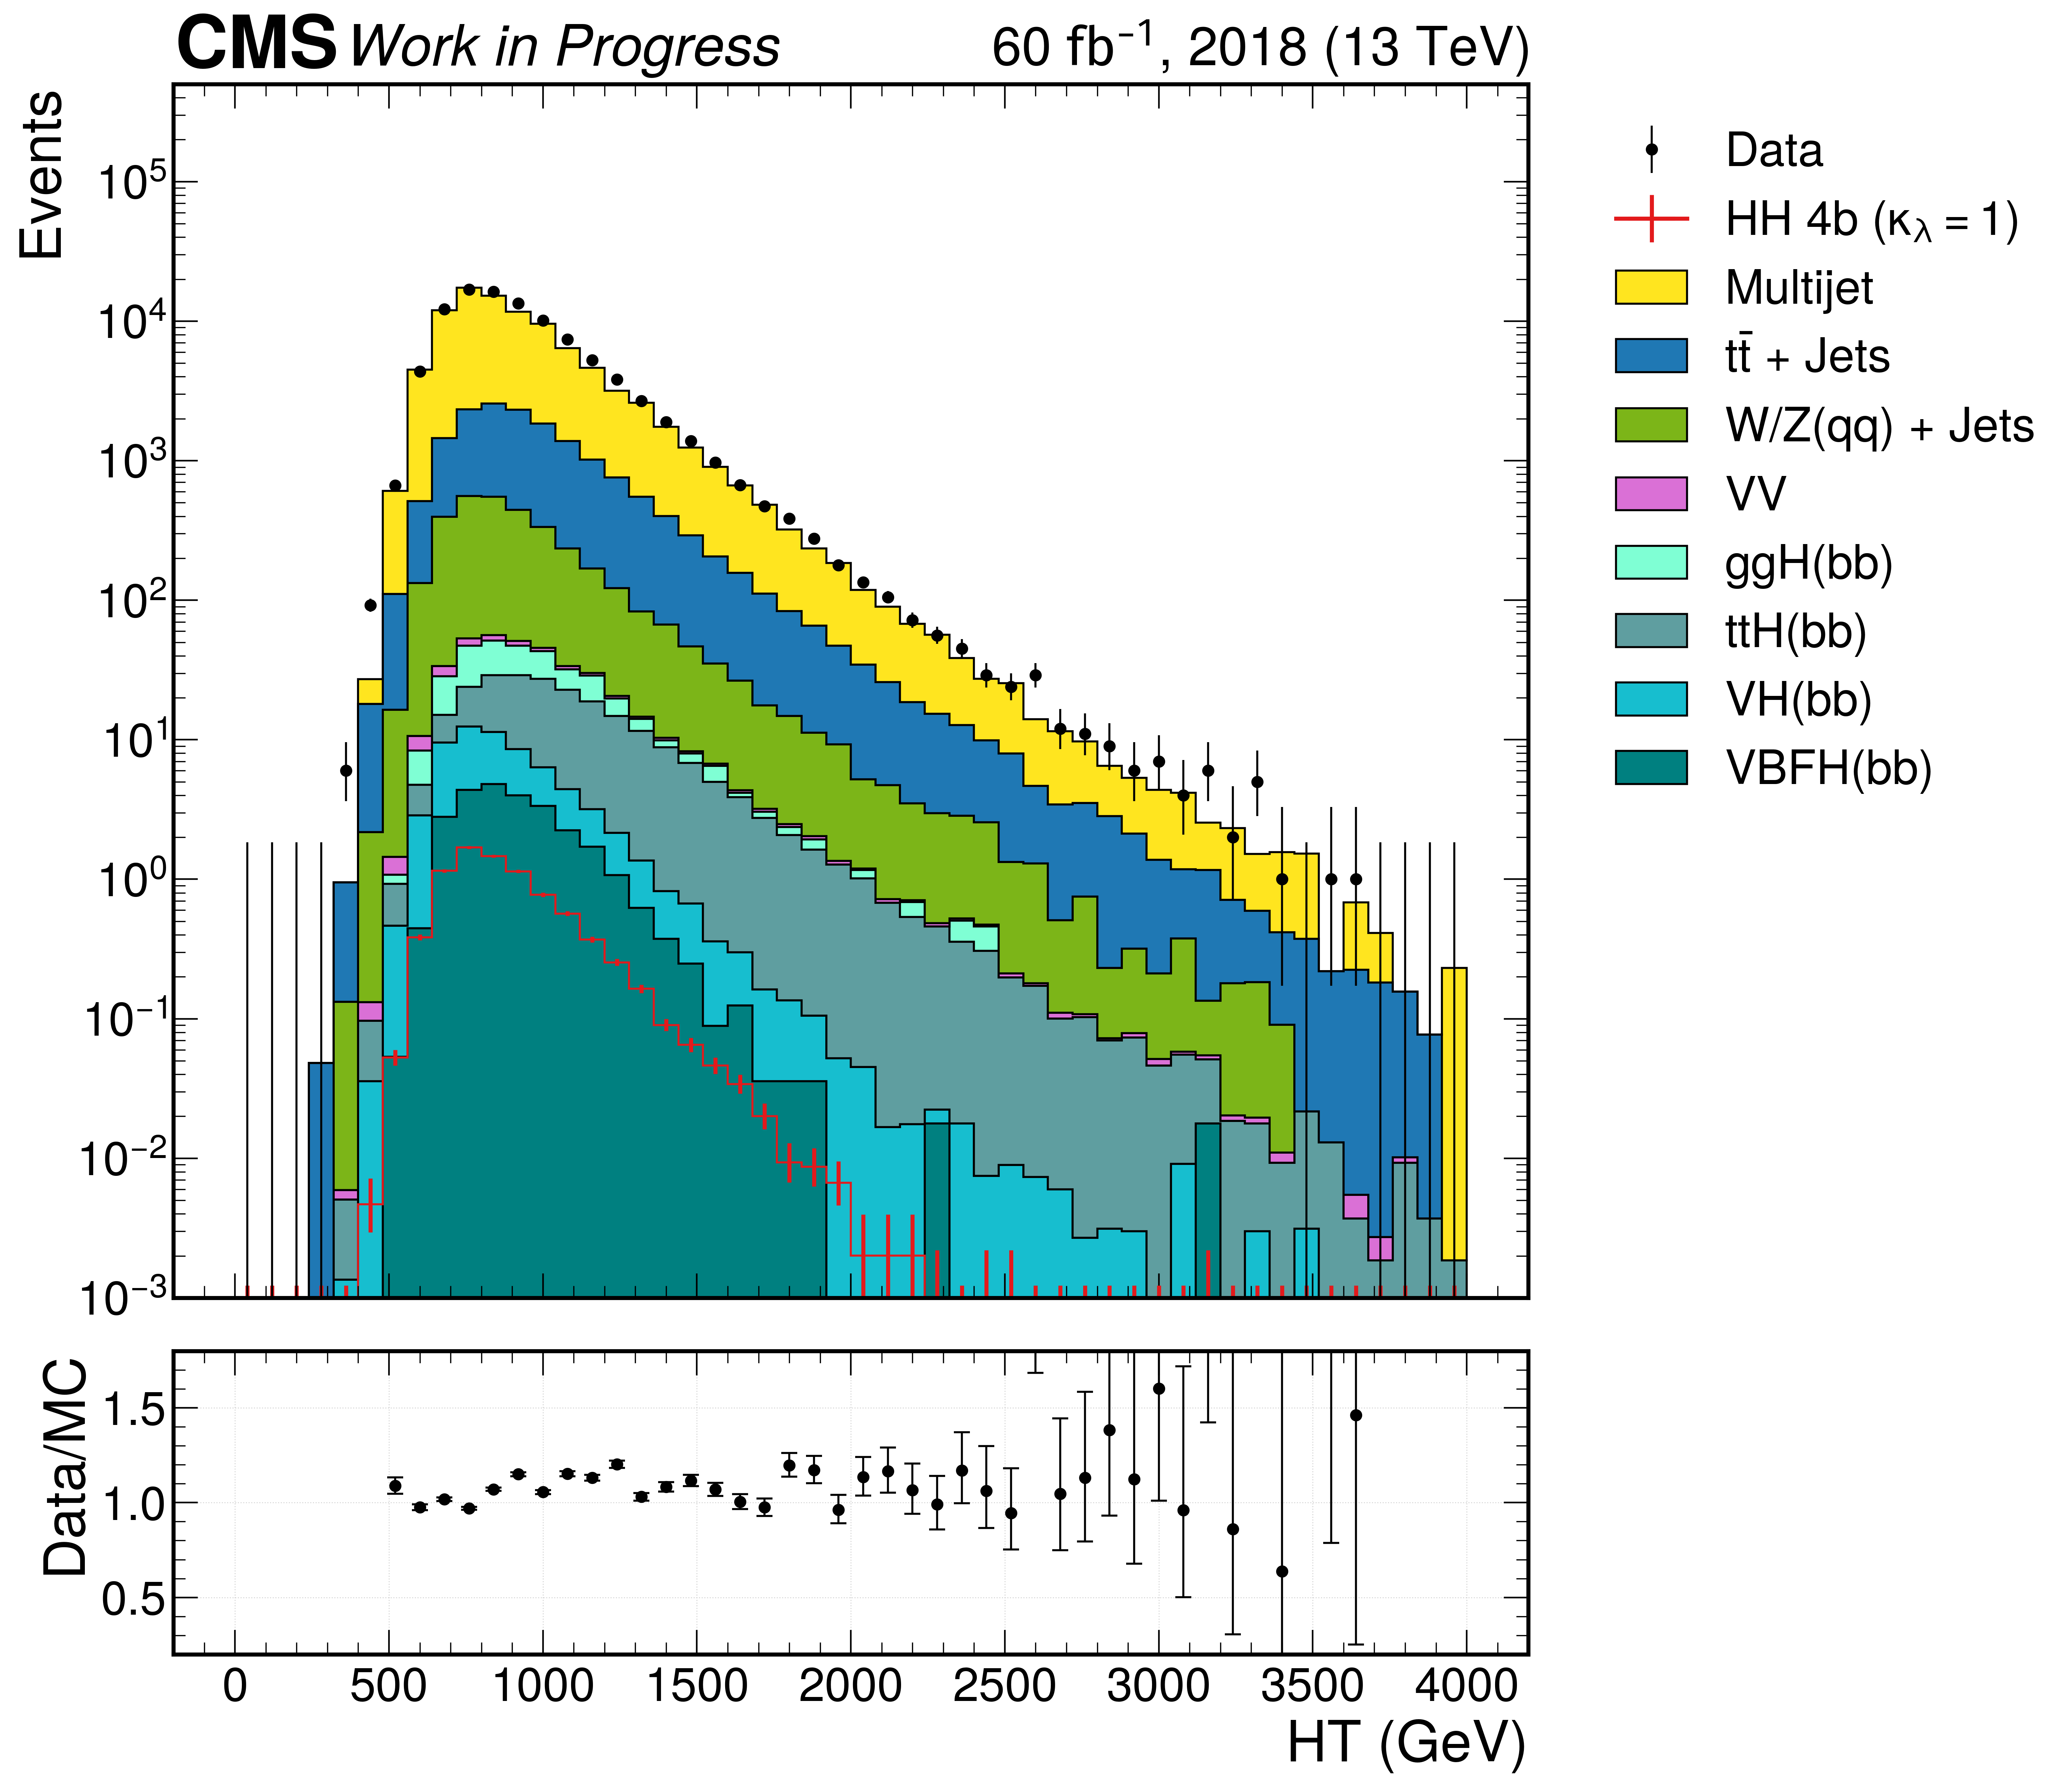

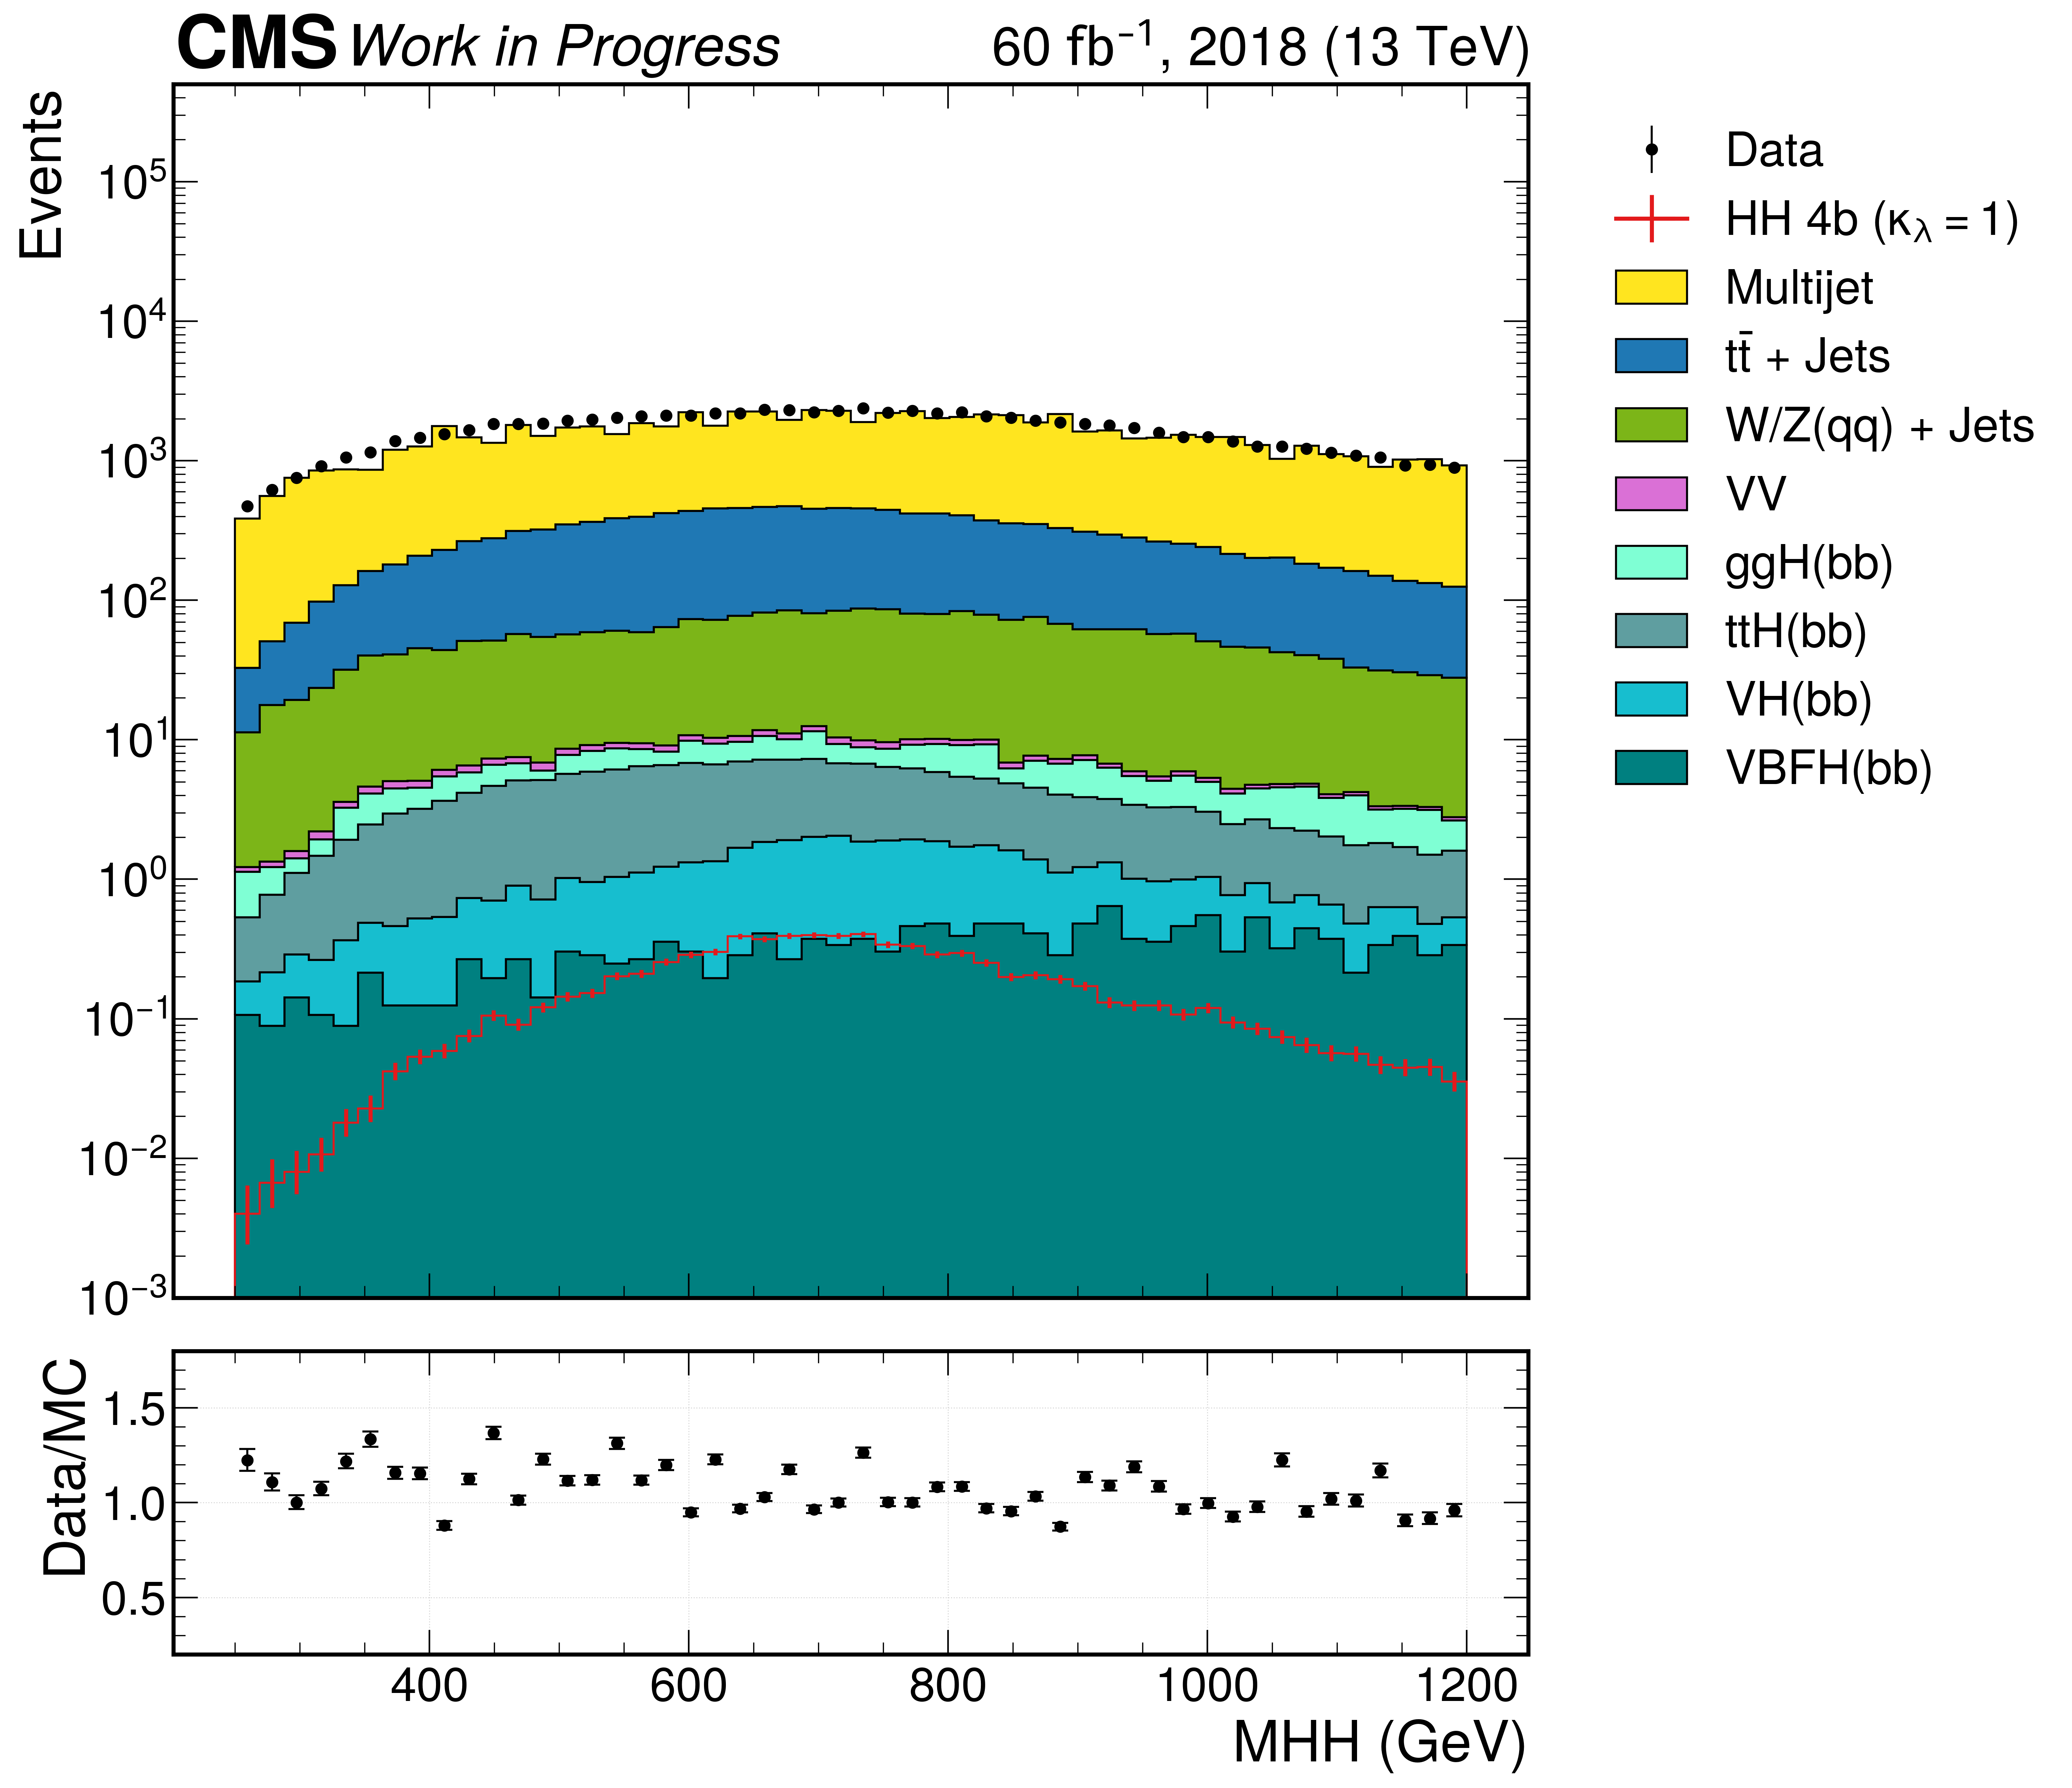

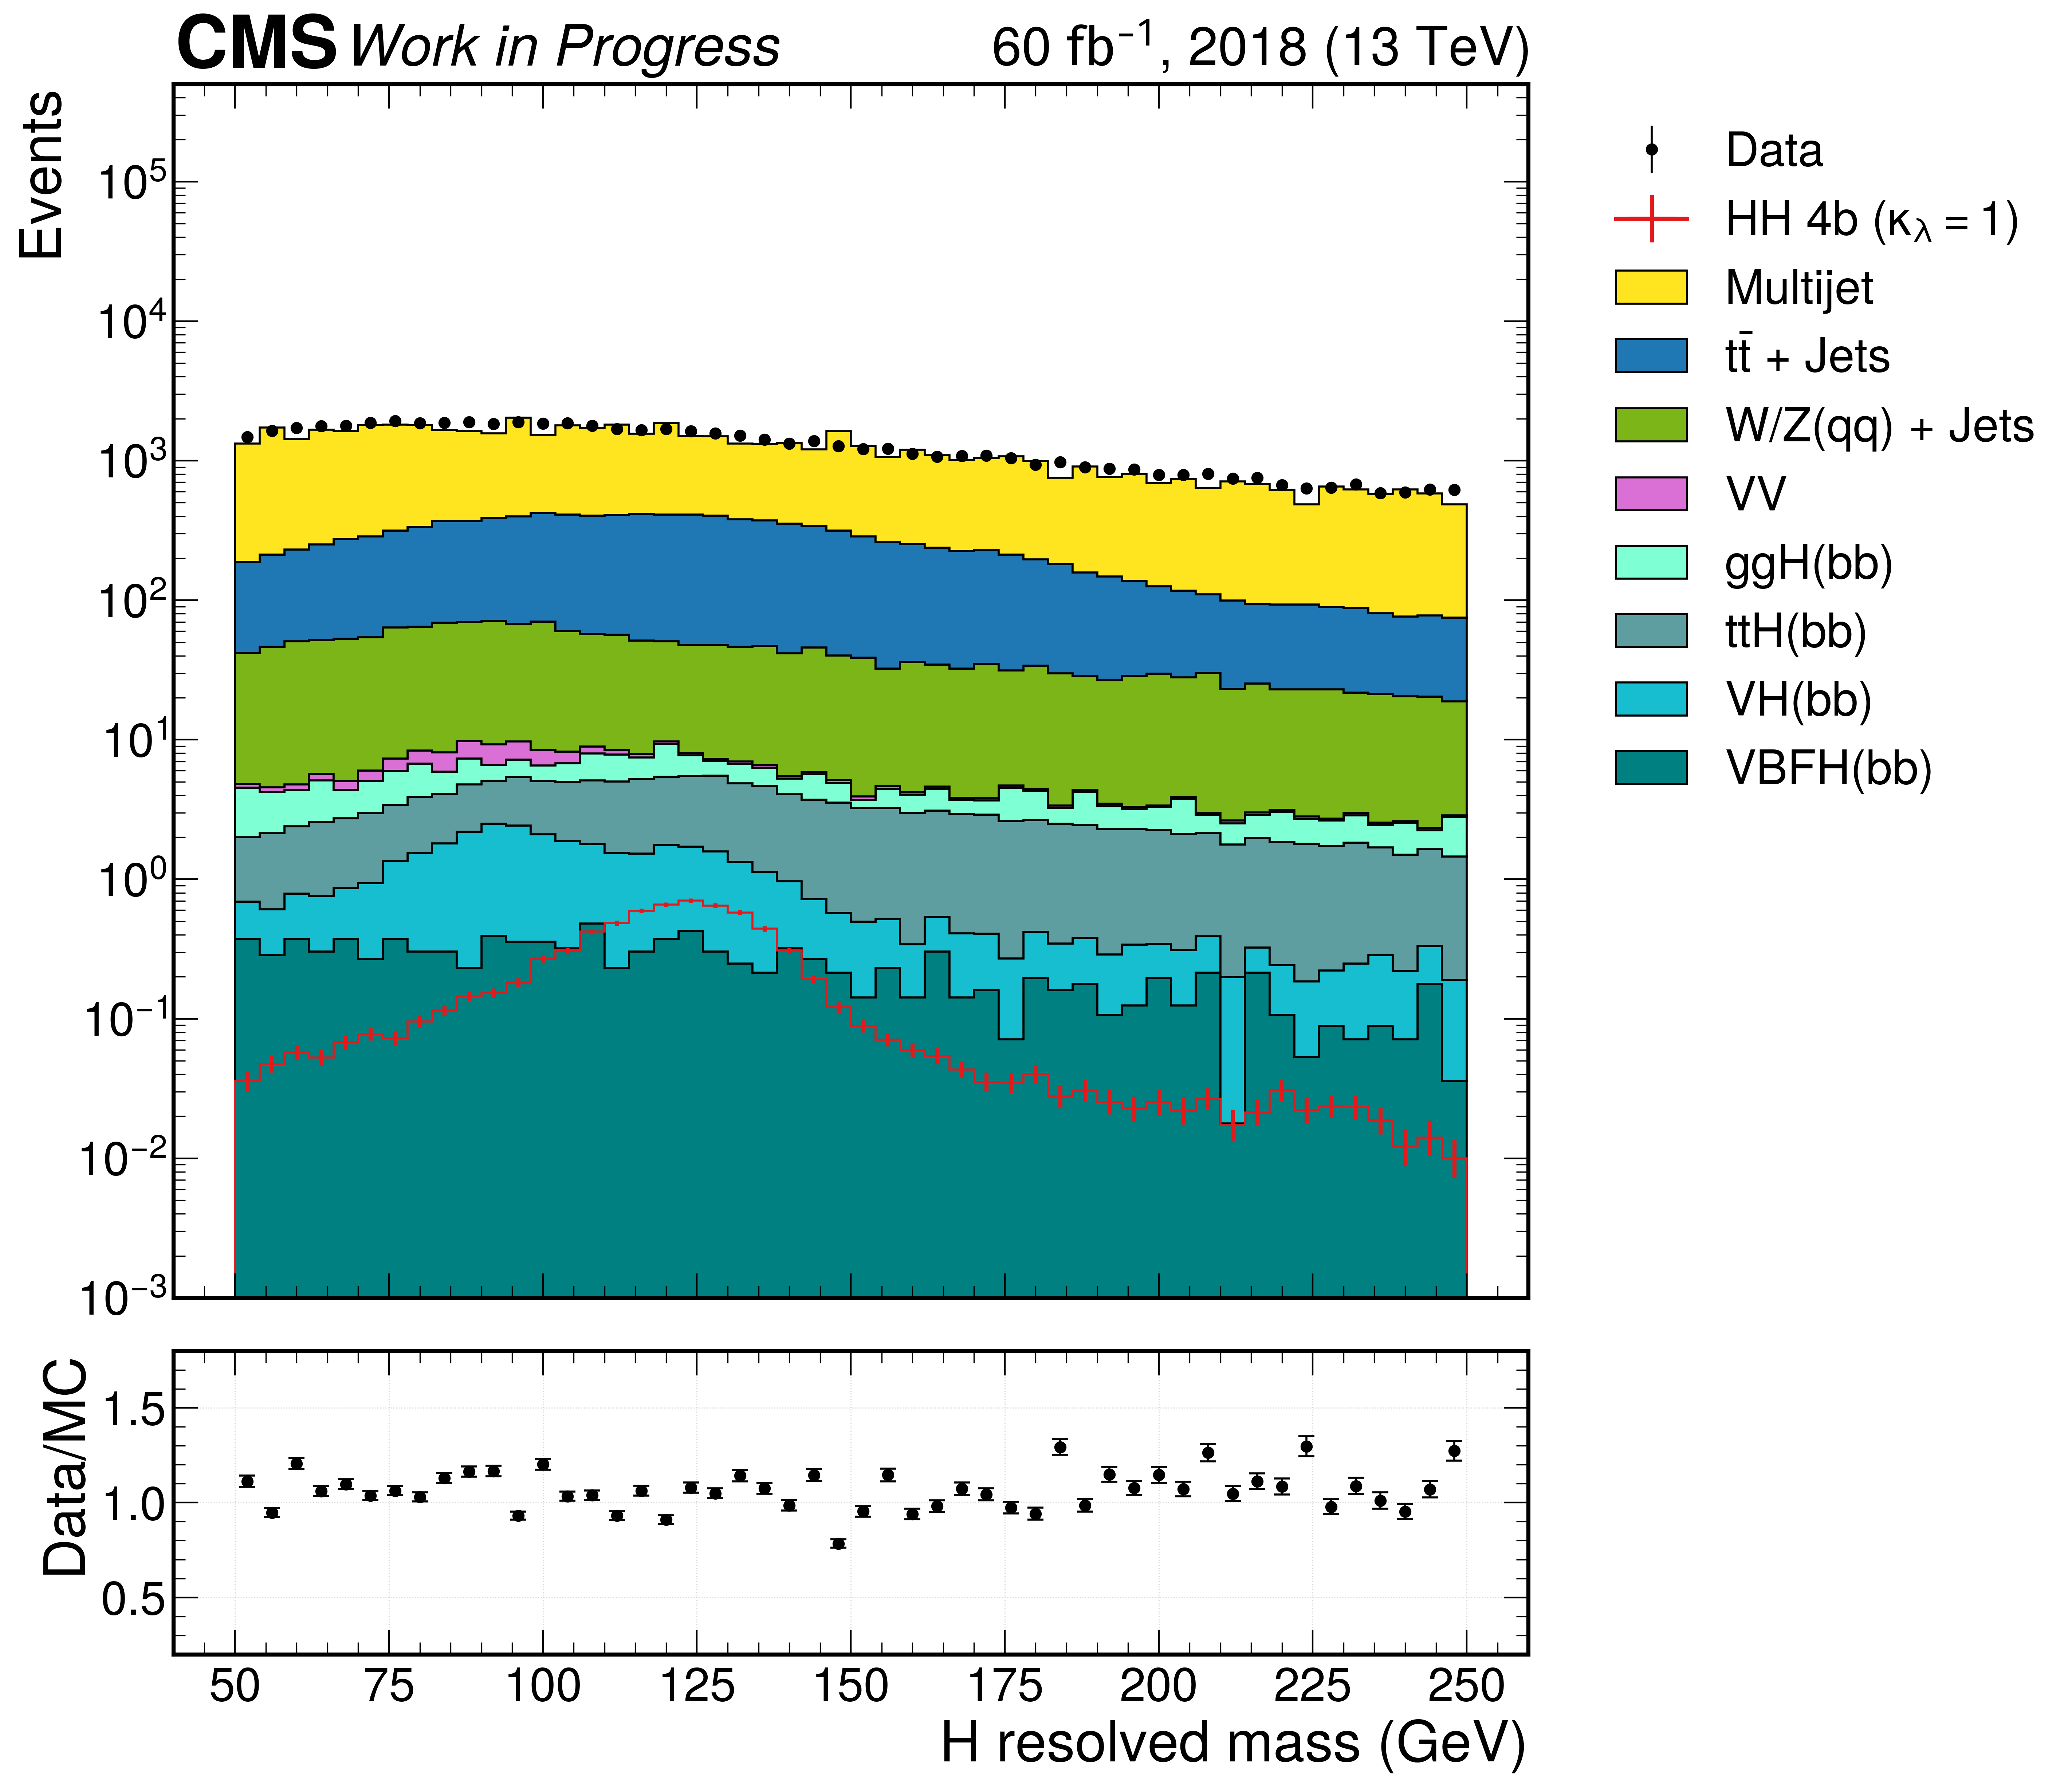

In [56]:
ylims = {
    "2018": 5e5,
}
color_by_sample["qcd"] = "#FFE51F"

# {var: (bins, label)}
control_plot_vars = [
    # var must match key in events dictionary (i.e. as saved in parquet file)
    ShapeVar(var="ak8FatJetPt0", label=r"$p_T^{j1}$ (GeV)", bins=[50, 300, 1500]),
    ShapeVar(var="ak8FatJetPt1", label=r"$p_T^{j2}$ (GeV)", bins=[50, 300, 1500]),
    ShapeVar(
        var="ak8FatJetPNetMass0",
        label=r"$m_{reg}^{j1}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetPNetMass1",
        label=r"$m_{reg}^{j2}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetMsd0",
        label=r"$m_{SD}^{j1}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetMsd1",
        label=r"$m_{SD}^{j2}$ (GeV)",
        bins=[19, 60, 250],
        significance_dir="bin",
    ),
    ShapeVar(
        var="ak8FatJetPNetXbb0",
        label=r"$T_{Xbb}^{j1}$",
        bins=[50, 0.97, 1],
    ),
    ShapeVar(
        var="ak8FatJetPNetXbb1",
        label=r"$T_{Xbb}^{j2}$",
        bins=[50, 0.0, 1],
    ),
    ShapeVar(
        var="ht",
        label=r"HT (GeV)",
        bins=[50, 0, 4000],
    ),
    ShapeVar(
        var="hh_mass",
        label=r"MHH (GeV)",
        bins=[50, 250, 1200],
    ),
    ShapeVar(
        var="hr_mass",
        label=r"H resolved mass (GeV)",
        bins=[50, 50, 250],
    ),
]

hists = {}
for shape_var in control_plot_vars:
    if shape_var.var not in hists:
        hists[shape_var.var] = utils.singleVarHist(
            events_dict,
            shape_var,
            weight_key="weight",
            selection=selection_btags,
        )

for shape_var in control_plot_vars:
    name = f"{plot_dir}/{shape_var.var}.pdf"
    plotting.ratioHistPlot(
        hists[shape_var.var],
        year,
        ["hh4b"],
        bg_keys,
        name=name,
        show=True,
        log=True,
        plot_significance=False,
        significance_dir=shape_var.significance_dir,
        ratio_ylims=[0.2, 1.8],
        ylim=ylims[year],
        energy="13"
    )
    # break

## Cut-based selection

pass


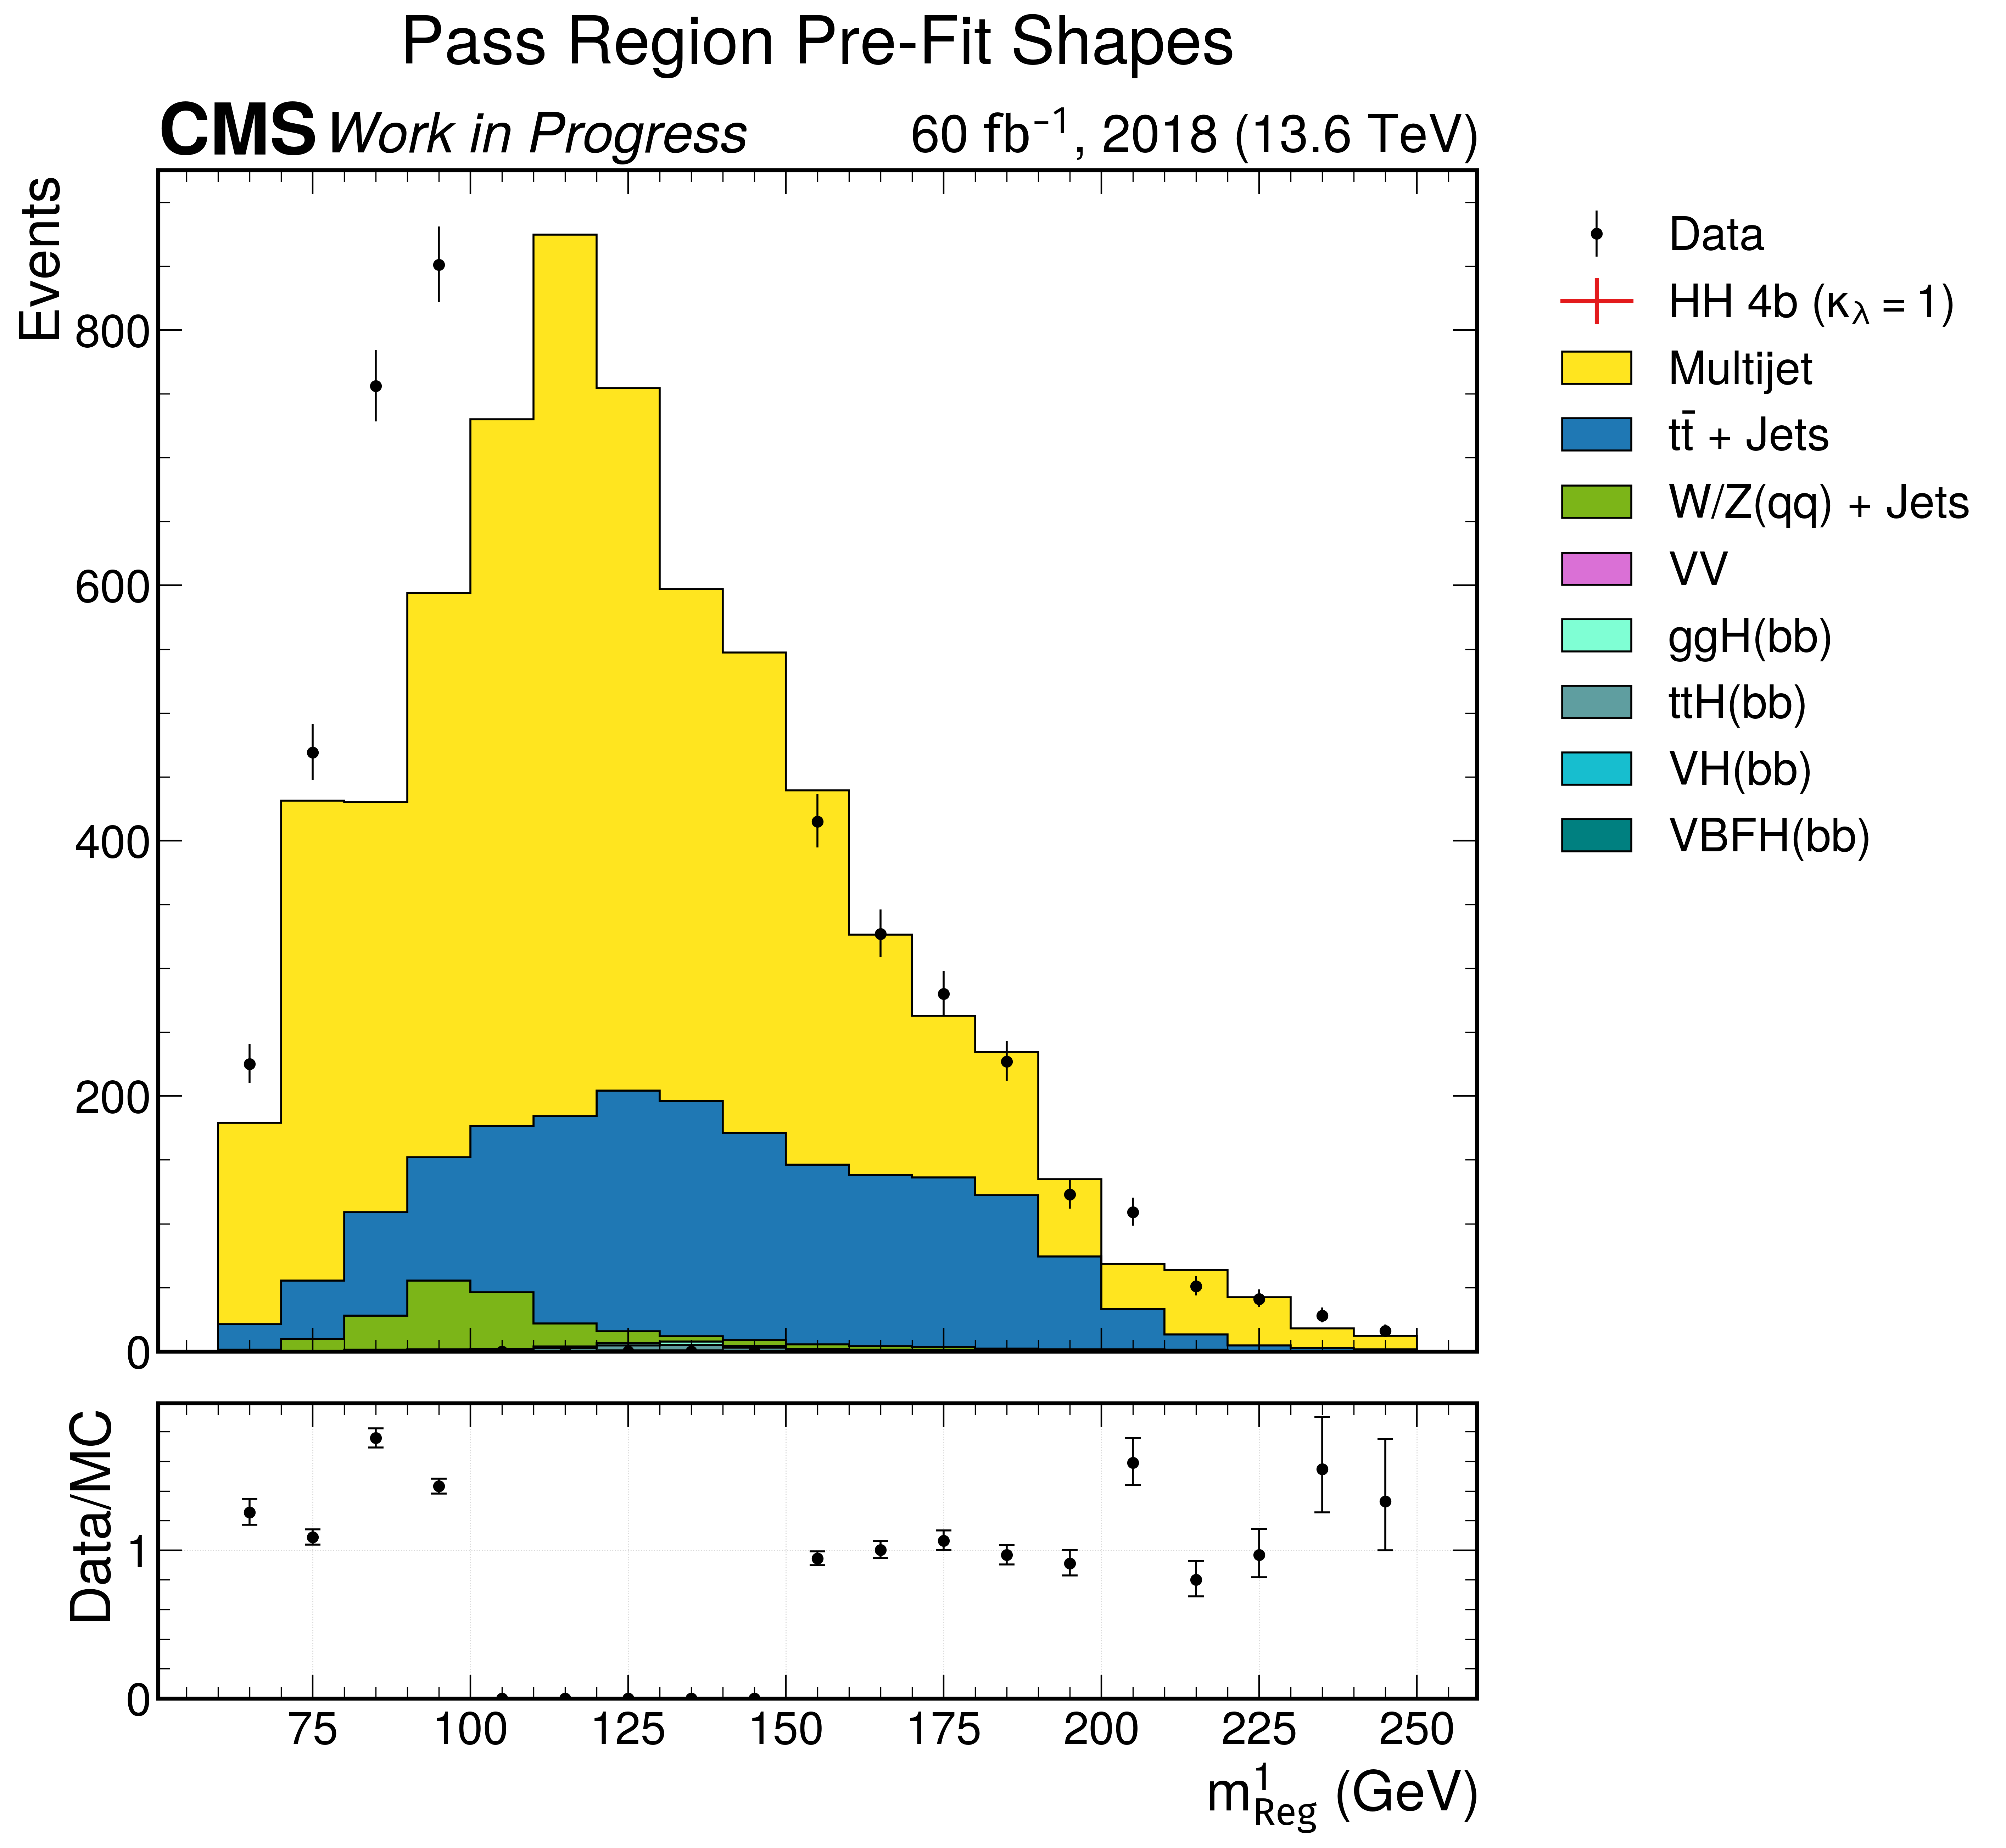

In [58]:
# {label: {cutvar: [min, max], ...}, ...}
selection_regions = {
    "pass": Region(
        cuts={
            #"ak4JetOutsidebtagDeepFlavB0": [0.71, CUT_MAX_VAL],
            #"ak4JetOutsidebtagDeepFlavB1": [0.71, CUT_MAX_VAL],
            "nbjets_pnet_ak4": [2, 3],
            "hr_mass": [100, 150],
        },
        label="Pass",
    ),
}

fit_shape_var = ShapeVar(
    "ak8FatJetPNetMass0",
    r"$m^{1}_\mathrm{Reg}$ (GeV)",
    [19, 60, 250],
    reg=True,
    blind_window=[100, 150],
)

bb_masks = postprocessing.bb_assignment(events_dict)

templates = postprocessing.get_templates(
    events_dict,
    bb_masks,
    year,
    ["hh4b"],
    selection_regions,
    [fit_shape_var],
    {},
    template_dir,
    bg_keys,
    plot_dir,
    cutflow,
    weight_key="weight",
    # weight_shifts=weight_shifts,
    show=True,
)